In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import make_scorer, r2_score

df = pd.read_csv('6) daily_consumption_data_full.csv', parse_dates=['date'])

### Note: In this script, we will only train model 4 from before + A few new models. 
### Previously, we learned that model 4 using cbrt transformation without feature scaling was the optimal model based on performance and complexity. We will explore this combination further using model 4 as well as a few new models.

In [2]:
# Categorisation of input variables
weather_features = [
    'temp_max_today', 'humidity_min_today', 'humidity_max_today', 'windspeed_max_today', 'precip_sum_today', 'solarradiation_sum_today',
    'humidity_at_peak_consumption_today', 'windspeed_at_peak_consumption_today', 'precip_at_peak_consumption_today', 
    'solarradiation_at_peak_consumption_today', 'temp_range_today', 'windspeed_min_today'
]

temporal_features = [
    'is_winter', 'is_summer', 'is_autumn', 'is_weekend', 'is_holiday', 'day_of_week_sin', 
    'day_of_week_cos', 'week_of_month_sin', 'week_of_month_cos'
]

consumption_features = [
    'consumption_sum_today', 'consumption_peak_today', 'consumption_min_today', 'prev_day_peak', 'same_day_last_week_peak', 
    'avg_peak_3d', 'avg_peak_7d', 'max_peak_7d', 'max_peak_3d'
]

household_features = [
    'household_size', 'male_occupants', 'female_occupants', 'count_children', 'ownership_owned', 
    'ownership_rented', 'ownership_other', 'work_from_home', 'housing_house', 'housing_apartment', 
    'count_rooms', 'electric_central_heating', 'heating_manual_boiler', 'heating_thermostatic_valves', 
    'heating_auto_set_times', 'heating_auto_temp_control', 'heating_not_sure', 'uses_electric_heater'
]

pricing_features = [
    'prop_low_price', 'prop_high_price', 'tariff_at_peak_consumption_today'
]

attitudinal_and_behavioural_features = [
    'interest_in_renewable_energy', 'interest_in_microgeneration', 'climate_change_concern', 
    'lifestyle_environment', 'smart_meter_bill_understanding', 'smart_meter_consumption_understanding'
]

appliance_features = [
    'washing_machine_fixed_schedule', 'tumble_dryer_fixed_schedule', 'dishwasher_fixed_schedule', 
    'immersion_water_heater_fixed_schedule', 'electric_oven_fixed_schedule', 'electric_hob_fixed_schedule', 
    'ironing_fixed_schedule', 'electric_shower_fixed_schedule', 'kettle_fixed_schedule', 'lighting_fixed_schedule', 
    'electric_heater_fixed_schedule', 'washer-dryer_combined_timer_use', 'washing_machine_timer_use', 
    'tumble_dryer_timer_use', 'dishwasher_timer_use', 'electric_space_heating_timer_use', 
    'washer-dryer_combined_ownership', 'washing_machine_ownership', 'tumble_dryer_ownership', 'dishwasher_ownership', 
    'electric_space_heating_ownership', 'count_low_efficiency_bulbs', 'total_refrigeration_units', 
    'count_cooking_appliances', 'count_laundry_appliances', 'count_kitchen_appliances', 
    'count_heating_water_appliances', 'count_entertainment_devices', 'count_computing_devices', 'count_tv', 
    'tv_energy_score'
]

In [3]:
# Apply cube root transformation to 'consumption_peak_next_day'
df['cbrt_consumption_peak_next_day'] = np.cbrt(df['consumption_peak_next_day'])

### Hyperparameter Tuning: As mentioned previously, this script explores a more focused range of hyperparameters informed by past results. In addition, the number of iterations in the RandomSearch has been increased from 100 to 200.

In [4]:
# Previously the following was the best set of hyperparameters for the optimal model (model 4)
'''
n_estimators: 1270
max_depth: 8
learning_rate: 0.018057171166114286
subsample: 0.7390362533589154
colsample_bytree: 0.7292919068542159
min_child_weight: 5
gamma: 0.05667096138379524
reg_alpha: 0.45240482674645155
reg_lambda: 0.4500867470007611
'''

# Define the improved parameter grid for Random Search based on previous results
param_grid = {
    'n_estimators': randint(800, 2000),  # Widened range around previous best (1270) to accommodate different model complexities
    'max_depth': randint(4, 12),  # Widened range around previous best (8) for varying feature sets
    'learning_rate': loguniform(0.01, 0.29), # Same as before. Best was 0.018
    'subsample': uniform(0.5, 0.5),  # Same range as before, centered around previous best (0.739)
    'colsample_bytree': uniform(0.5, 0.5),  # Same range as before, centered around previous best (0.729)
    'min_child_weight': randint(1, 10),  # Same as previous (best was 5)- Accommodates varying model complexities
    'gamma': uniform(0, 0.3),  # Lowered the upper bound based on previous best (0.057)
    'reg_alpha': loguniform(1e-3, 1),  # Changed to loguniform to explore lower values more thoroughly. Previous best was 0.452
    'reg_lambda': loguniform(1e-3, 1)  # Changed to loguniformto explore lower values more thoroughly. Previous best was 0.450
}

# Define date ranges for folds
folds = [
    ('2013-01-08', '2013-08-31', '2013-09-01', '2013-09-30'),
    ('2013-01-08', '2013-09-30', '2013-10-01', '2013-10-31'),
    ('2013-01-08', '2013-10-31', '2013-11-01', '2013-11-30')
]

# Custom functions to calculate error metrics (for cbrt transformation)
def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true**3 - y_pred**3))

def custom_mape(y_true, y_pred):
    y_true_inv = y_true**3
    y_pred_inv = y_pred**3
    mask = y_true_inv != 0
    return np.mean(np.abs((y_true_inv[mask] - y_pred_inv[mask]) / y_true_inv[mask])) * 100

def custom_wape(y_true, y_pred):
    y_true_inv = y_true**3
    y_pred_inv = y_pred**3
    return np.sum(np.abs(y_true_inv - y_pred_inv)) / np.sum(np.abs(y_true_inv)) * 100

def custom_r2(y_true, y_pred):
    return r2_score(y_true**3, y_pred**3)

# Define WAPE scorer
wape_scorer = make_scorer(custom_wape, greater_is_better=False)

# Create a global create_dataset (needed for learning curve)
def create_dataset(df, start_date, end_date, features, target):
    mask = (df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))
    X = df.loc[mask, features]
    y = df.loc[mask, target]
    household_ids = df.loc[mask, 'household_id']
    dates = df.loc[mask, 'date']
    return X, y, household_ids, dates

In [5]:
# Function to plot the test results
def plot_test_results(model_name, predictions, actuals, household_ids, dates):
    # Convert predictions and actuals back to original scale
    predictions_original = predictions**3
    actuals_original = actuals**3

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'household_id': household_ids,
        'date': dates,
        'actual': actuals_original,
        'predicted': predictions_original
    })

    # Scatter plot of Actual vs Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals_original, predictions_original, alpha=0.5)
    plt.plot([actuals_original.min(), actuals_original.max()], [actuals_original.min(), actuals_original.max()], 'r--')
    plt.xlabel('Actual Peak Consumption (kWh)')
    plt.ylabel('Predicted Peak Consumption (kWh)')
    plt.title(f'{model_name}: Actual vs Predicted Peak Consumption')
    plt.show()

    # Time series plot for a few random households
    np.random.seed(1)
    random_households = np.random.choice(results_df['household_id'].unique(), 3, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, household in enumerate(random_households, 1):
        household_data = results_df[results_df['household_id'] == household]
        plt.subplot(3, 1, i)
        plt.plot(household_data['date'], household_data['actual'], label='Actual')
        plt.plot(household_data['date'], household_data['predicted'], label='Predicted')
        plt.title(f'Household {household}')
        plt.xlabel('Date')
        plt.ylabel('Peak Consumption (kWh)')
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Error distribution
    errors = actuals_original - predictions_original
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error (kWh)')
    plt.ylabel('Frequency')
    plt.title(f'{model_name}: Distribution of Prediction Errors')
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics for {model_name}:")
    print(f"Mean Error: {errors.mean():.4f}")
    print(f"Median Error: {np.median(errors):.4f}")
    print(f"Standard Deviation of Error: {errors.std():.4f}")
    print(f"5th Percentile of Error: {np.percentile(errors, 5):.4f}")
    print(f"95th Percentile of Error: {np.percentile(errors, 95):.4f}")
    print()
    print("___________________________________________________________")

In [6]:
def run_model(features, target, df, folds, param_grid, model_name):
    # Initialise lists to store metrics
    mae_scores_train, mape_scores_train, wape_scores_train, r2_scores_train = [], [], [], []
    mae_scores_val, mape_scores_val, wape_scores_val, r2_scores_val = [], [], [], []
    feature_importances = []
    best_params_list = []

    print(f"\n--- Running {model_name} ---\n")

    for fold, (train_start, train_end, val_start, val_end) in enumerate(folds, 1):
        print(f"Fold {fold}")
        print(f"Training period: {train_start} to {train_end}")
        print(f"Validation period: {val_start} to {val_end}")
        
        # Create training and validation sets 
        X_train, y_train, _, _ = create_dataset(df, train_start, train_end, features, target)
        X_val, y_val, _, _ = create_dataset(df, val_start, val_end, features, target)
        
        tscv = TimeSeriesSplit(n_splits=3)
        
        # Random Search CV
        model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, enable_categorical=True)
        random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                           n_iter=200, cv=tscv.split(X_train), 
                                           scoring=wape_scorer,  
                                           n_jobs=-1, random_state=1)
        random_search.fit(X_train, y_train)
        
        # Get best model and parameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        best_params_list.append(best_params)
        
        # Training Metrics
        train_predictions = best_model.predict(X_train)
        train_mae = custom_mae(y_train, train_predictions)
        train_mape = custom_mape(y_train, train_predictions)
        train_wape = custom_wape(y_train, train_predictions)
        train_r2 = custom_r2(y_train, train_predictions)
        mae_scores_train.append(train_mae)
        mape_scores_train.append(train_mape)
        wape_scores_train.append(train_wape)
        r2_scores_train.append(train_r2)
        
        # Validation Metrics
        val_predictions = best_model.predict(X_val)
        val_mae = custom_mae(y_val, val_predictions)
        val_mape = custom_mape(y_val, val_predictions)
        val_wape = custom_wape(y_val, val_predictions)
        val_r2 = custom_r2(y_val, val_predictions)
        mae_scores_val.append(val_mae)
        mape_scores_val.append(val_mape)
        wape_scores_val.append(val_wape)
        r2_scores_val.append(val_r2)
        
        # Feature importances
        importances = best_model.feature_importances_
        feature_importances.append(dict(zip(features, importances)))
        
        # Print results for each fold
        print(f"Training metrics for fold {fold}:")
        print(f"MAE: {train_mae:.4f}")
        print(f"MAPE: {train_mape:.4f}%")
        print(f"WAPE: {train_wape:.4f}%")
        print(f"R²: {train_r2:.4f}")
        
        print(f"Validation metrics for fold {fold}:")
        print(f"MAE: {val_mae:.4f}")
        print(f"MAPE: {val_mape:.4f}%")
        print(f"WAPE: {val_wape:.4f}%")
        print(f"R²: {val_r2:.4f}")
        print("Best parameters:", best_params)
        print("Top 15 Feature importances:")
        for feature, importance in sorted(zip(features, importances), key=lambda x: x[1], reverse=True)[:15]:
            print(f"{feature}: {importance:.3f}")
        print("\n")

    avg_train_mae = np.mean(mae_scores_train)
    avg_train_mape = np.mean(mape_scores_train)
    avg_train_wape = np.mean(wape_scores_train)
    avg_train_r2 = np.mean(r2_scores_train)
    avg_val_mae = np.mean(mae_scores_val)
    avg_val_mape = np.mean(mape_scores_val)
    avg_val_wape = np.mean(wape_scores_val)
    avg_val_r2 = np.mean(r2_scores_val)

    print(f"Average Training MAE across folds: {avg_train_mae:.4f}")
    print(f"Average Training MAPE across folds: {avg_train_mape:.4f}%")
    print(f"Average Training WAPE across folds: {avg_train_wape:.4f}%")
    print(f"Average Training R² across folds: {avg_train_r2:.4f}")
    print(f"Average Validation MAE across folds: {avg_val_mae:.4f}")
    print(f"Average Validation MAPE across folds: {avg_val_mape:.4f}%")
    print(f"Average Validation WAPE across folds: {avg_val_wape:.4f}%")
    print(f"Average Validation R² across folds: {avg_val_r2:.4f}")

    # Calculate average feature importances
    avg_importances = {}
    for feature in features:
        avg_importances[feature] = np.mean([fold[feature] for fold in feature_importances])

    print("\nTop 15 Average feature importances across folds:")
    for feature, importance in sorted(avg_importances.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(f"{feature}: {importance:.3f}")

    # Define test set dates
    test_start = '2013-12-01'
    test_end = '2013-12-30'

    # Check that the test set dates do not overlap with train set dates
    last_train_date = pd.to_datetime(test_start) - pd.Timedelta(days=1)
    if last_train_date < pd.to_datetime(folds[-1][2]):
        raise ValueError(f"Test set dates ({test_start} to {test_end}) overlap with training data. Last training date should be before {test_start}.")

    # Create final training and test sets
    X_train_final, y_train_final, _, _ = create_dataset(df, df['date'].min(), pd.to_datetime(test_start) - pd.Timedelta(days=1), features, target)
    X_test, y_test, test_household_ids, test_dates = create_dataset(df, test_start, test_end, features, target)

    # Train final model
    final_params = best_params_list[np.argmin(wape_scores_val)]
    final_model = XGBRegressor(**final_params, enable_categorical=True)
    final_model.fit(X_train_final, y_train_final)

    print("\nBest hyperparameters used for the final model:")
    for param, value in final_params.items():
        print(f"{param}: {value}")

    # Make predictions and calculate test metrics
    test_predictions = final_model.predict(X_test)
    test_mae = custom_mae(y_test, test_predictions)
    test_mape = custom_mape(y_test, test_predictions)
    test_wape = custom_wape(y_test, test_predictions)
    test_r2 = custom_r2(y_test, test_predictions)
    print(f"\nMetrics on test set:")
    print(f"MAE: {test_mae:.4f}")
    print(f"MAPE: {test_mape:.4f}%")
    print(f"WAPE: {test_wape:.4f}%")
    print(f"R²: {test_r2:.4f}")

    # Plot feature importances
    final_importances = final_model.feature_importances_
    feature_imp = pd.DataFrame(sorted(zip(final_importances, features)), columns=['Value','Feature'])

    plt.figure(figsize=(10, min(20, len(features) * 0.3)))
    plt.barh(feature_imp['Feature'], feature_imp['Value'])
    plt.title(f'Feature Importances - {model_name}')
    plt.xlabel('Importance')

    for i, v in enumerate(feature_imp['Value']):
        plt.text(v, i, f' {v:.3f}', va='center')

    plt.tight_layout()
    plt.show()

    return final_model, test_mae, test_mape, test_wape, test_r2, dict(zip(features, final_importances)), avg_train_mae, avg_train_mape, avg_train_wape, avg_train_r2, avg_val_mae, avg_val_mape, avg_val_wape, avg_val_r2, test_predictions, y_test, test_household_ids, test_dates


--- Running Model 3 ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30
Training metrics for fold 1:
MAE: 0.2957
MAPE: 36.6362%
WAPE: 26.3832%
R²: 0.7476
Validation metrics for fold 1:
MAE: 0.3181
MAPE: 45.9162%
WAPE: 31.3212%
R²: 0.6167
Best parameters: {'colsample_bytree': 0.6197231184523402, 'gamma': 0.03942469816123817, 'learning_rate': 0.017245896409210384, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1854, 'reg_alpha': 0.7775015465464755, 'reg_lambda': 0.010890244739547786, 'subsample': 0.7978125490674748}
Top 15 Feature importances:
avg_peak_7d: 0.317
avg_peak_3d: 0.120
consumption_peak_today: 0.059
consumption_sum_today: 0.050
max_peak_3d: 0.021
uses_electric_heater: 0.014
max_peak_7d: 0.014
same_day_last_week_peak: 0.012
tumble_dryer_ownership: 0.011
count_kitchen_appliances: 0.009
household_size: 0.009
prev_day_peak: 0.008
immersion_water_heater_fixed_schedule: 0.008
day_of_week_sin: 0.007
count_cooking_appliances: 0.00

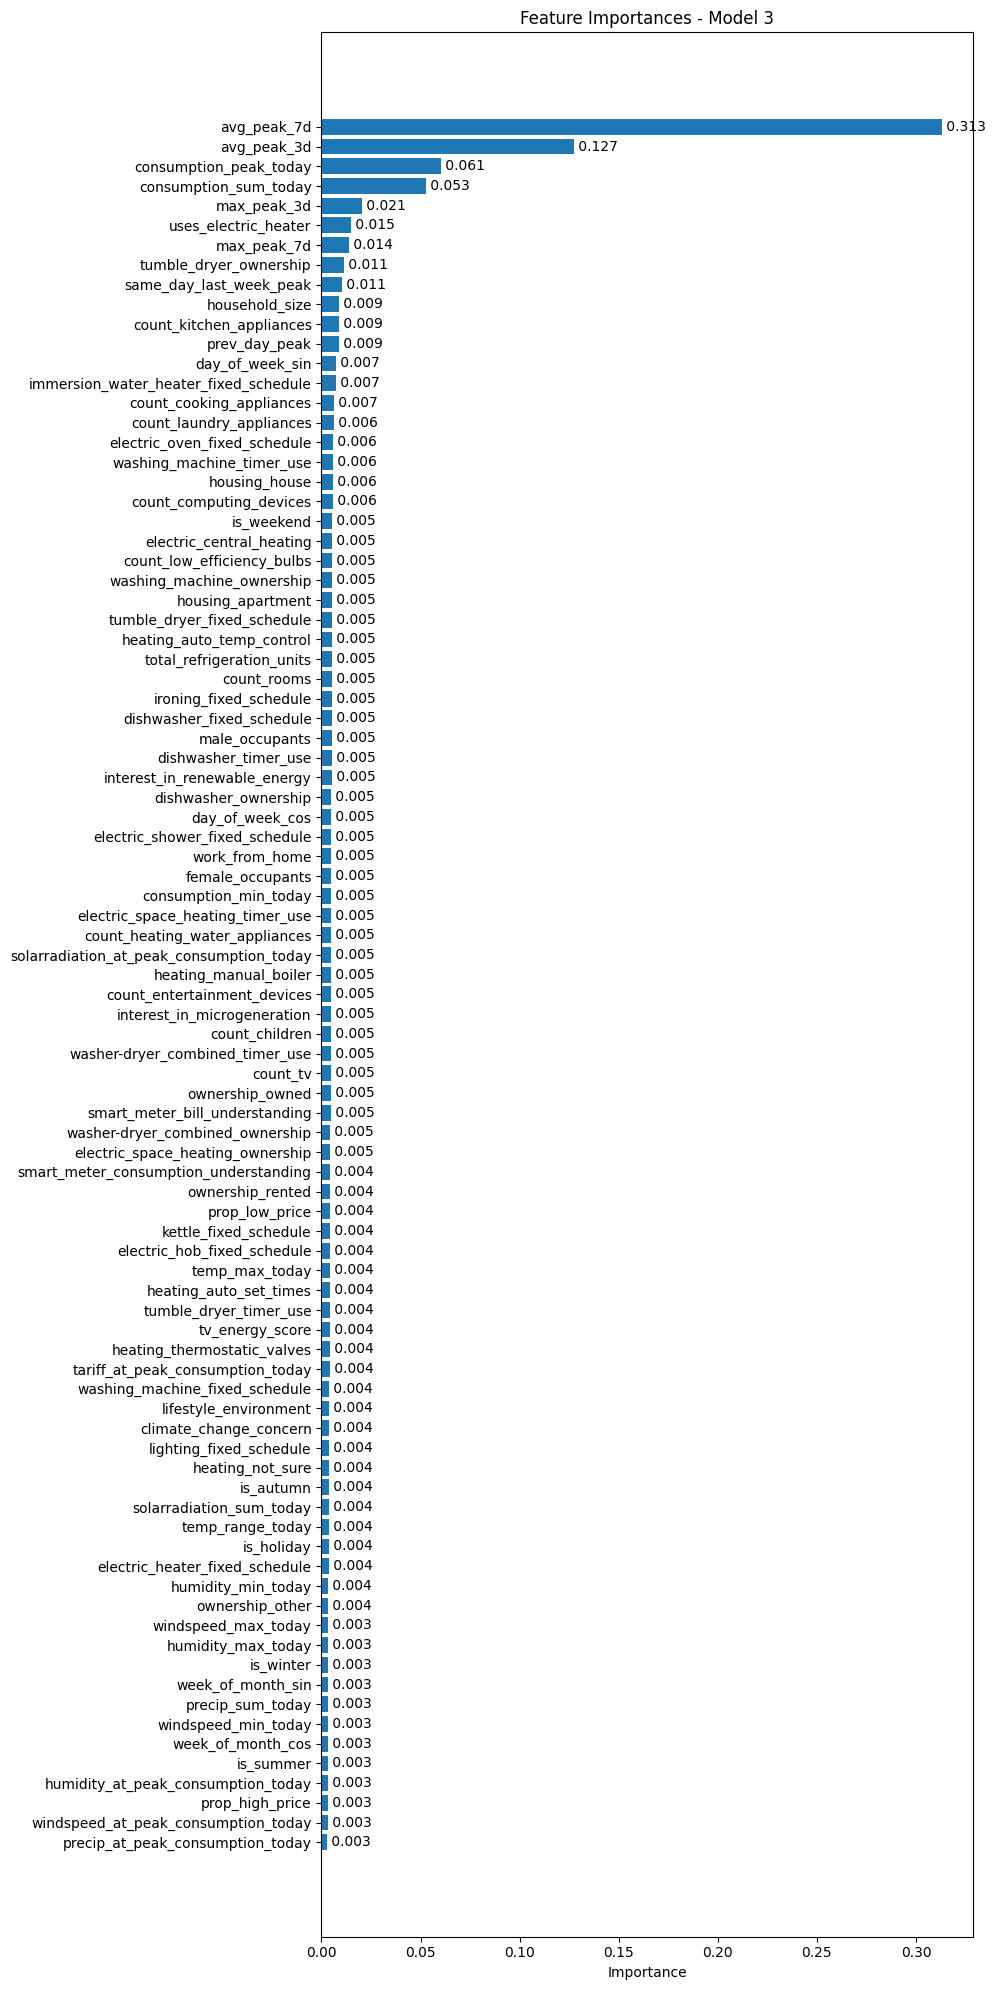


--- Running Model 4 (Only Top 15 Features from Model 3) ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30
Training metrics for fold 1:
MAE: 0.3139
MAPE: 38.7670%
WAPE: 28.0093%
R²: 0.7154
Validation metrics for fold 1:
MAE: 0.3261
MAPE: 45.8255%
WAPE: 32.1114%
R²: 0.5954
Best parameters: {'colsample_bytree': 0.8141545187606786, 'gamma': 0.08702905550622775, 'learning_rate': 0.010319801450719758, 'max_depth': 11, 'min_child_weight': 4, 'n_estimators': 1920, 'reg_alpha': 0.03562893127903027, 'reg_lambda': 0.5613291025737852, 'subsample': 0.713237394250698}
Top 15 Feature importances:
avg_peak_7d: 0.513
avg_peak_3d: 0.149
consumption_peak_today: 0.101
consumption_sum_today: 0.049
max_peak_7d: 0.025
uses_electric_heater: 0.020
max_peak_3d: 0.019
tumble_dryer_ownership: 0.017
count_kitchen_appliances: 0.017
same_day_last_week_peak: 0.017
immersion_water_heater_fixed_schedule: 0.015
day_of_week_sin: 0.015
count_cooking_appliances: 0.015
prev_d

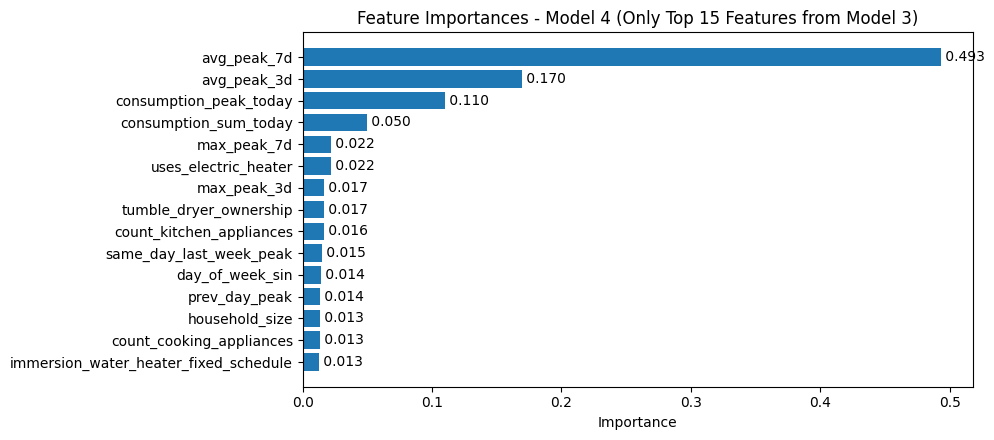


--- Model Comparison (3 and 4) ---
Model 3 Avg Train MAE: 0.2966
Model 3 Avg Train MAPE: 36.9371%
Model 3 Avg Train WAPE: 26.6562%
Model 3 Avg Train R²: 0.7405
Model 3 Avg Val MAE: 0.3389
Model 3 Avg Val MAPE: 44.0733%
Model 3 Avg Val WAPE: 30.2219%
Model 3 Avg Val R²: 0.6170
Model 3 Test MAE: 0.3749
Model 3 Test MAPE: 48.5312%
Model 3 Test WAPE: 29.2680%
Model 3 Test R²: 0.6546

Model 4 (Only Top 15 Features from Model 3) Avg Train MAE: 0.3133
Model 4 (Only Top 15 Features from Model 3) Avg Train MAPE: 39.1597%
Model 4 (Only Top 15 Features from Model 3) Avg Train WAPE: 28.1623%
Model 4 (Only Top 15 Features from Model 3) Avg Train R²: 0.7085
Model 4 (Only Top 15 Features from Model 3) Avg Val MAE: 0.3477
Model 4 (Only Top 15 Features from Model 3) Avg Val MAPE: 44.3078%
Model 4 (Only Top 15 Features from Model 3) Avg Val WAPE: 31.0137%
Model 4 (Only Top 15 Features from Model 3) Avg Val R²: 0.5938
Model 4 (Only Top 15 Features from Model 3) Test MAE: 0.3798
Model 4 (Only Top 15 Feat

In [7]:
# Define feature sets
model_3_features = temporal_features + consumption_features + weather_features + household_features + pricing_features + attitudinal_and_behavioural_features + appliance_features

# Run model 3 to get importances for model 4
model_3, mae_3, mape_3, wape_3, r2_3, importances_3, avg_train_mae_3, avg_train_mape_3, avg_train_wape_3, avg_train_r2_3, avg_val_mae_3, avg_val_mape_3, avg_val_wape_3, avg_val_r2_3, test_predictions_3, y_test_3, test_household_ids_3, test_dates_3 = run_model(model_3_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 3")

# Let's train model 4, which only uses the top 15 features from model 3
model_4_features = [feature for feature, importance in sorted(importances_3.items(), key=lambda x: x[1], reverse=True)[:15]]
model_4, mae_4, mape_4, wape_4, r2_4, importances_4, avg_train_mae_4, avg_train_mape_4, avg_train_wape_4, avg_train_r2_4, avg_val_mae_4, avg_val_mape_4, avg_val_wape_4, avg_val_r2_4, test_predictions_4, y_test_4, test_household_ids_4, test_dates_4 = run_model(model_4_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 4 (Only Top 15 Features from Model 3)")

# Compare the models
print("\n--- Model Comparison (3 and 4) ---")
print(f"Model 3 Avg Train MAE: {avg_train_mae_3:.4f}")
print(f"Model 3 Avg Train MAPE: {avg_train_mape_3:.4f}%")
print(f"Model 3 Avg Train WAPE: {avg_train_wape_3:.4f}%")
print(f"Model 3 Avg Train R²: {avg_train_r2_3:.4f}")
print(f"Model 3 Avg Val MAE: {avg_val_mae_3:.4f}")
print(f"Model 3 Avg Val MAPE: {avg_val_mape_3:.4f}%")
print(f"Model 3 Avg Val WAPE: {avg_val_wape_3:.4f}%")
print(f"Model 3 Avg Val R²: {avg_val_r2_3:.4f}")
print(f"Model 3 Test MAE: {mae_3:.4f}")
print(f"Model 3 Test MAPE: {mape_3:.4f}%")
print(f"Model 3 Test WAPE: {wape_3:.4f}%")
print(f"Model 3 Test R²: {r2_3:.4f}")

print(f"\nModel 4 (Only Top 15 Features from Model 3) Avg Train MAE: {avg_train_mae_4:.4f}")
print(f"Model 4 (Only Top 15 Features from Model 3) Avg Train MAPE: {avg_train_mape_4:.4f}%")
print(f"Model 4 (Only Top 15 Features from Model 3) Avg Train WAPE: {avg_train_wape_4:.4f}%")
print(f"Model 4 (Only Top 15 Features from Model 3) Avg Train R²: {avg_train_r2_4:.4f}")
print(f"Model 4 (Only Top 15 Features from Model 3) Avg Val MAE: {avg_val_mae_4:.4f}")
print(f"Model 4 (Only Top 15 Features from Model 3) Avg Val MAPE: {avg_val_mape_4:.4f}%")
print(f"Model 4 (Only Top 15 Features from Model 3) Avg Val WAPE: {avg_val_wape_4:.4f}%")
print(f"Model 4 (Only Top 15 Features from Model 3) Avg Val R²: {avg_val_r2_4:.4f}")
print(f"Model 4 (Only Top 15 Features from Model 3) Test MAE: {mae_4:.4f}")
print(f"Model 4 (Only Top 15 Features from Model 3) Test MAPE: {mape_4:.4f}%")
print(f"Model 4 (Only Top 15 Features from Model 3) Test WAPE: {wape_4:.4f}%")
print(f"Model 4 (Only Top 15 Features from Model 3) Test R²: {r2_4:.4f}")

# Compare feature importances
print("\n--- Top 15 Feature Importances Comparison ---")
print(f"\nModel 3:")
for feature, importance in sorted(importances_3.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"{feature}: {importance:.3f}")

print(f"\nModel 4 (Only Top 15 Features from Model 3):")
for feature, importance in sorted(importances_4.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"{feature}: {importance:.3f}")

print(f"\nNumber of features in Model 3: {len(model_3_features)}")
print(f"Number of features in Model 4 (Only Top 15 Features from Model 3): {len(model_4_features)}")

### Individual household features seem to have very little importance. We will agggregate some of those features and train a few more models.

In [8]:
# Heating control sophistication score
def heating_control_score(row):
    scores = [0]
    if row['heating_manual_boiler']:
        scores.append(1)
    if row['heating_thermostatic_valves']:
        scores.append(2)
    if row['heating_auto_set_times']:
        scores.append(3)
    if row['heating_auto_temp_control']:
        scores.append(4)
    if row['heating_not_sure']:
        return 0
    return max(scores)

df['heating_control_score'] = df.apply(heating_control_score, axis=1)

# Total appliance count
appliance_count_cols = ['count_cooking_appliances', 'count_laundry_appliances', 
                        'count_kitchen_appliances', 'count_heating_water_appliances', 
                        'count_entertainment_devices', 'count_computing_devices', 
                        'count_tv']

ownership_cols = ['washer-dryer_combined_ownership', 'washing_machine_ownership', 
                  'tumble_dryer_ownership', 'dishwasher_ownership', 'electric_space_heating_ownership']

df['total_appliance_count'] = df[appliance_count_cols].sum(axis=1) + df[ownership_cols].sum(axis=1)

# Schedule rigidity
fixed_schedule_cols = [col for col in df.columns if col.endswith('_fixed_schedule')]
df['schedule_rigidity'] = df[fixed_schedule_cols].sum(axis=1)

# Timer use aggregation
timer_use_cols = [col for col in df.columns if col.endswith('_timer_use')]
df['timer_use_score'] = df[timer_use_cols].sum(axis=1)

# People per room/ Household density
df['people_per_room'] = df['household_size'] / df['count_rooms']

# Electric heating reliance
df['electric_heating_score'] = df['electric_central_heating'].astype(int) + df['uses_electric_heater'].astype(int)

newly_aggregated_features = [
    'heating_control_score', 'total_appliance_count',
    'schedule_rigidity', 'timer_use_score', 'people_per_room', 'electric_heating_score'
]

# Convert aggregated features to numeric types
df['heating_control_score'] = pd.to_numeric(df['heating_control_score'], errors='coerce')
df['total_appliance_count'] = pd.to_numeric(df['total_appliance_count'], errors='coerce')
df['schedule_rigidity'] = pd.to_numeric(df['schedule_rigidity'], errors='coerce')
df['timer_use_score'] = pd.to_numeric(df['timer_use_score'], errors='coerce')
df['people_per_room'] = pd.to_numeric(df['people_per_room'], errors='coerce')
df['electric_heating_score'] = pd.to_numeric(df['electric_heating_score'], errors='coerce')

### Using the newly aggregated features, we will train model 5, 6, and 7.
#### Model 5: Combines all features from Model 3 with newly aggregated household features.
#### Model 6: Uses only the newly aggregated household features, excluding the individual features used for aggregation.
#### Model 7: Selects the top 15 most important features from Model 6 based on feature importances.



--- Running Model 5 (Model 3 with Aggregated Household Features) ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30
Training metrics for fold 1:
MAE: 0.2635
MAPE: 31.7685%
WAPE: 23.5067%
R²: 0.7974
Validation metrics for fold 1:
MAE: 0.3166
MAPE: 45.3339%
WAPE: 31.1761%
R²: 0.6191
Best parameters: {'colsample_bytree': 0.8241563780815623, 'gamma': 0.05098221426517733, 'learning_rate': 0.016540578683031364, 'max_depth': 11, 'min_child_weight': 5, 'n_estimators': 1449, 'reg_alpha': 0.8845998752143264, 'reg_lambda': 0.6724110524452301, 'subsample': 0.669615333889757}
Top 15 Feature importances:
avg_peak_7d: 0.343
avg_peak_3d: 0.071
consumption_peak_today: 0.053
consumption_sum_today: 0.027
uses_electric_heater: 0.012
max_peak_7d: 0.011
tumble_dryer_ownership: 0.010
count_kitchen_appliances: 0.008
electric_heating_score: 0.008
household_size: 0.007
same_day_last_week_peak: 0.007
washing_machine_timer_use: 0.007
max_peak_3d: 0.007
electric_cent

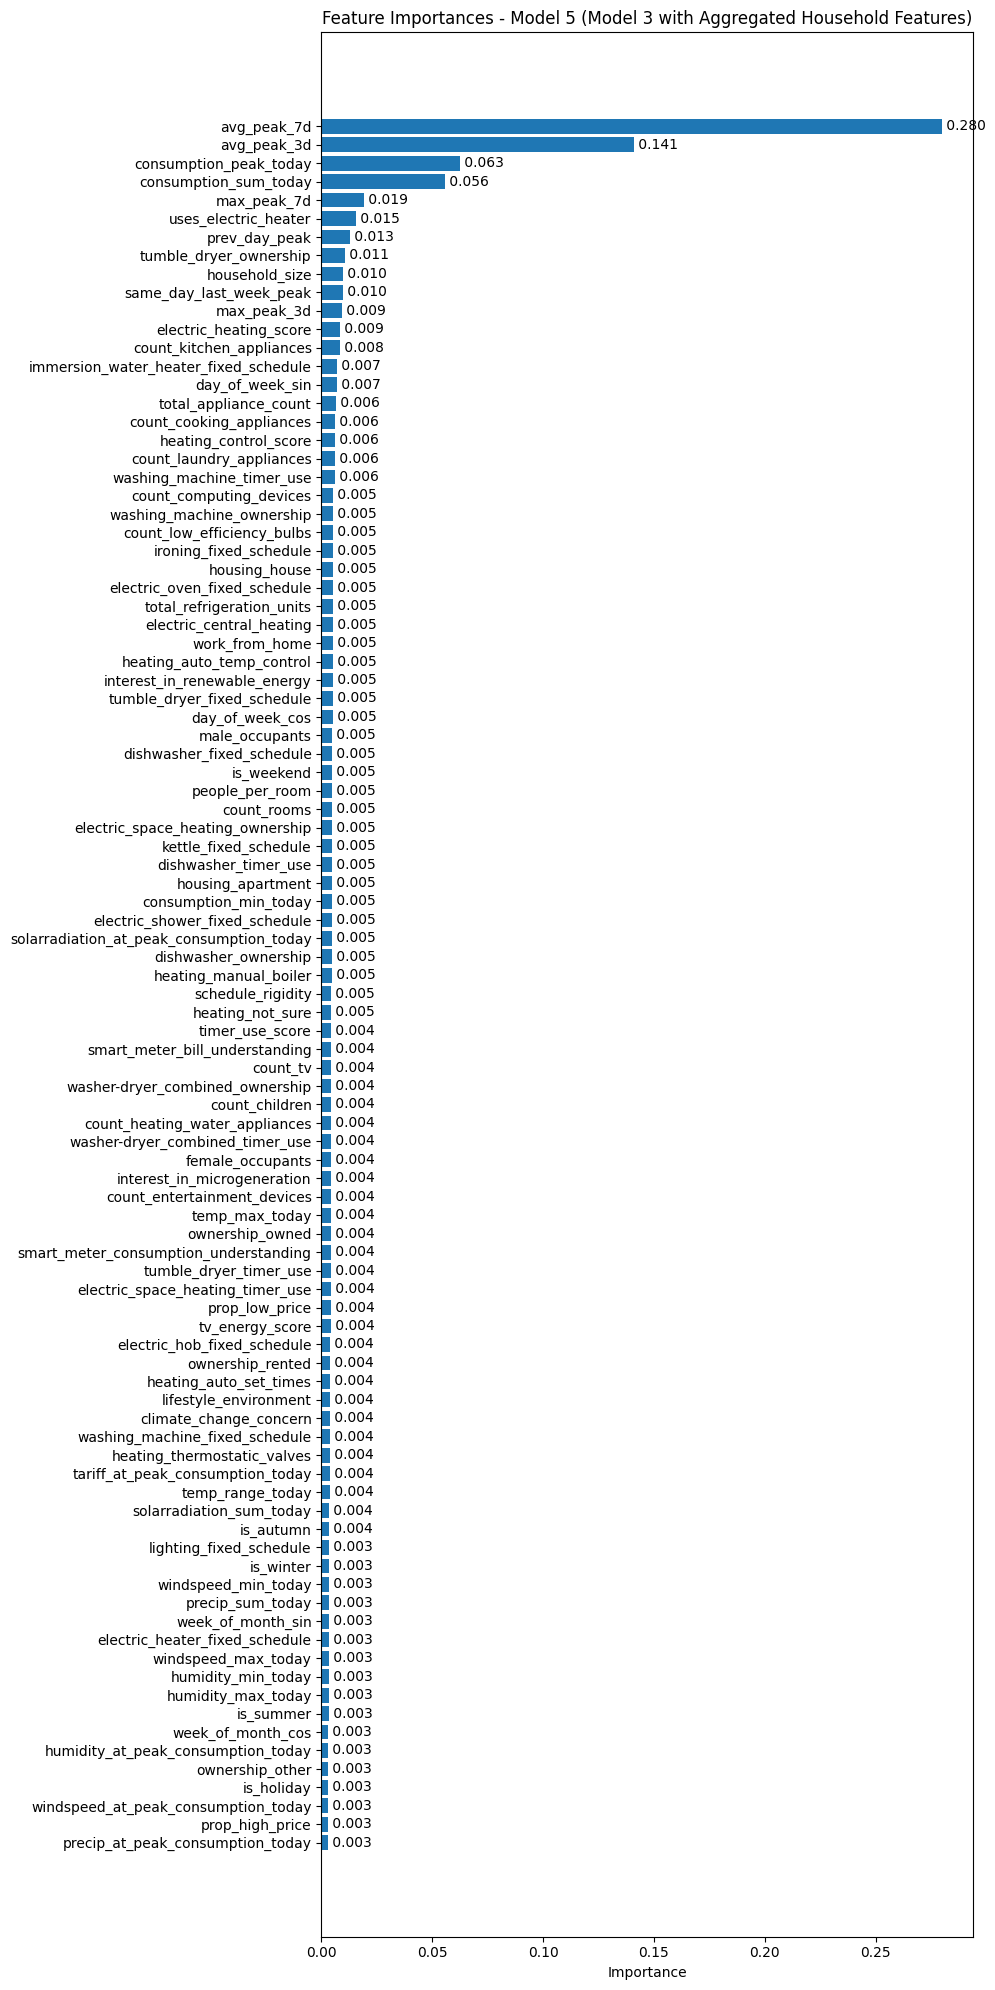


--- Running Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features) ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30
Training metrics for fold 1:
MAE: 0.2996
MAPE: 37.0994%
WAPE: 26.7324%
R²: 0.7413
Validation metrics for fold 1:
MAE: 0.3205
MAPE: 45.8186%
WAPE: 31.5624%
R²: 0.6116
Best parameters: {'colsample_bytree': 0.6197231184523402, 'gamma': 0.03942469816123817, 'learning_rate': 0.017245896409210384, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1854, 'reg_alpha': 0.7775015465464755, 'reg_lambda': 0.010890244739547786, 'subsample': 0.7978125490674748}
Top 15 Feature importances:
avg_peak_7d: 0.381
avg_peak_3d: 0.120
consumption_peak_today: 0.098
consumption_sum_today: 0.052
max_peak_3d: 0.025
max_peak_7d: 0.024
same_day_last_week_peak: 0.014
electric_heating_score: 0.012
prev_day_peak: 0.012
day_of_week_sin: 0.008
total_appliance_count: 0.008
heating_control_score: 0.007
count_low_efficiency_bul

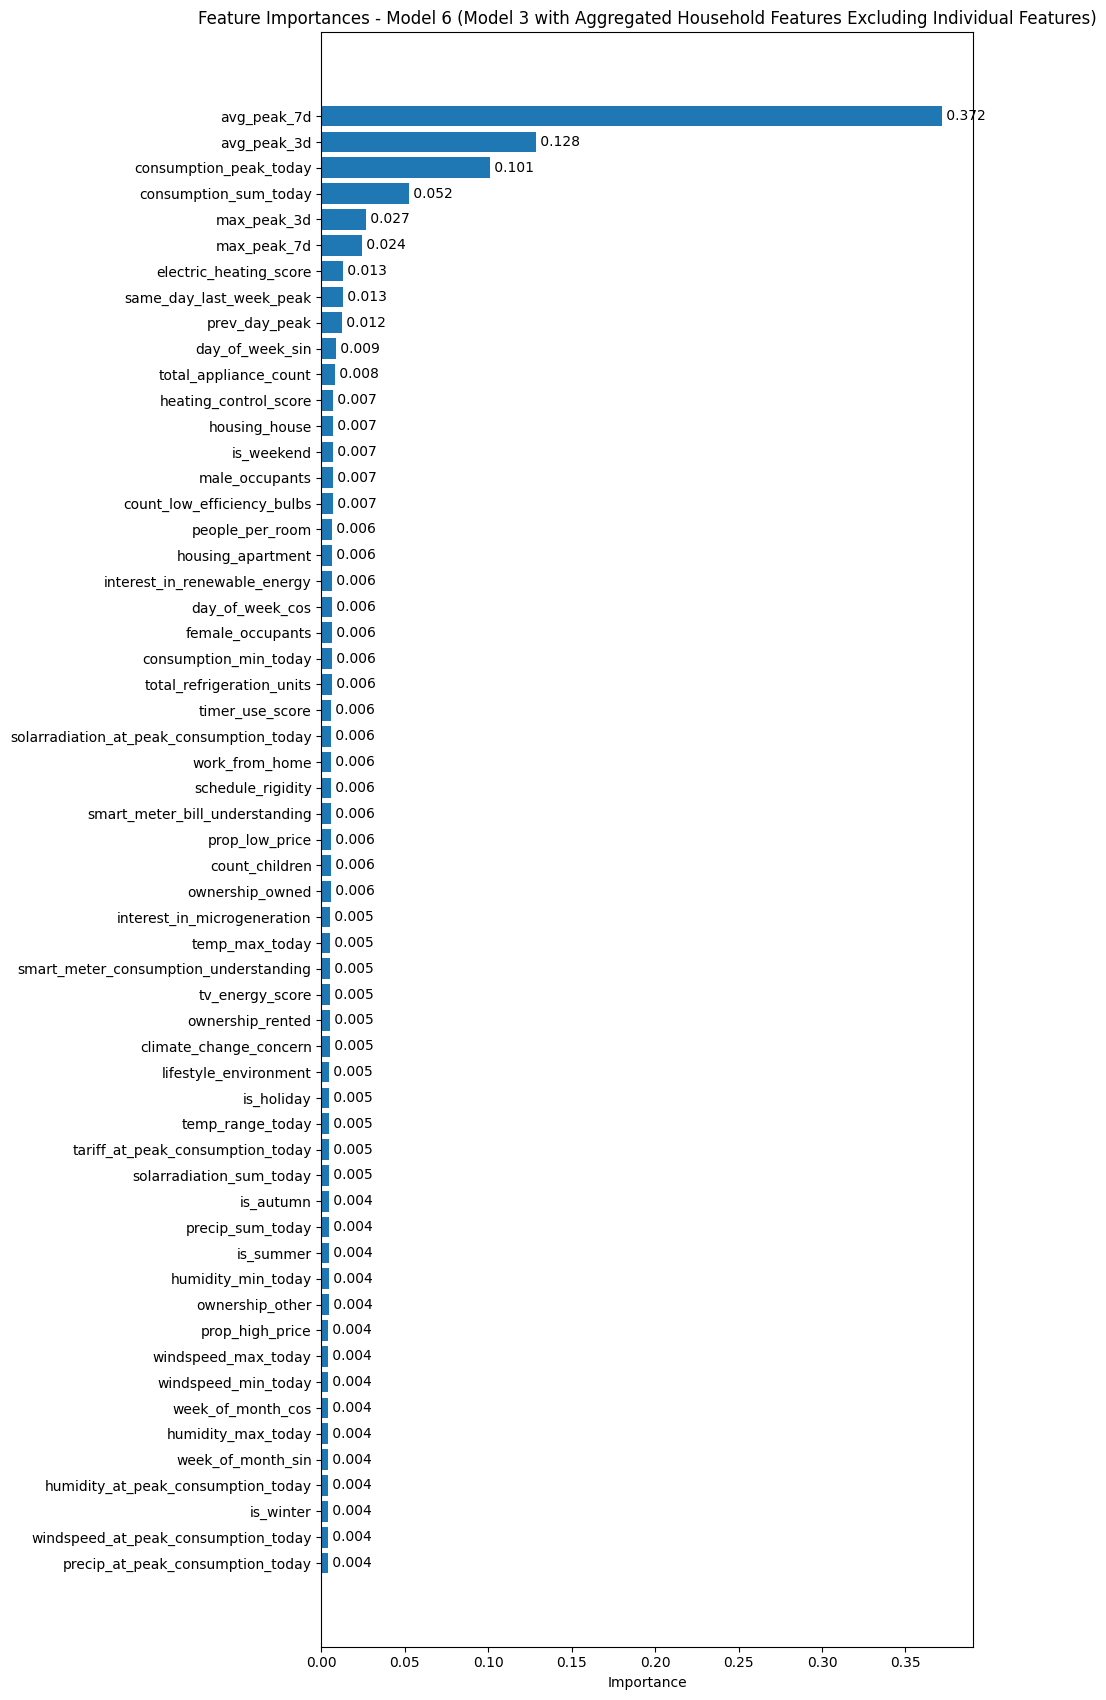


--- Running Model 7 (Only Top 15 Features from Model 6) ---

Fold 1
Training period: 2013-01-08 to 2013-08-31
Validation period: 2013-09-01 to 2013-09-30
Training metrics for fold 1:
MAE: 0.3078
MAPE: 37.8050%
WAPE: 27.4611%
R²: 0.7266
Validation metrics for fold 1:
MAE: 0.3255
MAPE: 45.5320%
WAPE: 32.0531%
R²: 0.5965
Best parameters: {'colsample_bytree': 0.9107233701131486, 'gamma': 0.06929656778448999, 'learning_rate': 0.012155804685643161, 'max_depth': 11, 'min_child_weight': 8, 'n_estimators': 1265, 'reg_alpha': 0.03167106930657741, 'reg_lambda': 0.01082535947895349, 'subsample': 0.7519352247855218}
Top 15 Feature importances:
avg_peak_7d: 0.568
avg_peak_3d: 0.113
consumption_peak_today: 0.108
consumption_sum_today: 0.037
max_peak_7d: 0.023
electric_heating_score: 0.018
same_day_last_week_peak: 0.016
heating_control_score: 0.015
total_appliance_count: 0.015
day_of_week_sin: 0.015
housing_house: 0.015
max_peak_3d: 0.014
prev_day_peak: 0.014
is_weekend: 0.014
male_occupants: 0.014



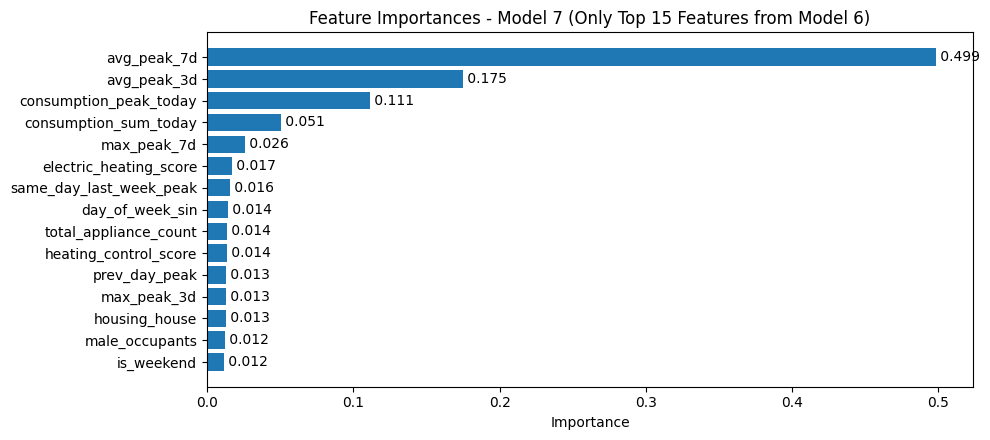


--- Final Model Comparison ---
Model 3 (Temporal + Consumption + Weather + Household, Pricing, Attitudinal, and Appliance Features):
  Avg Train MAE: 0.2966
  Avg Train MAPE: 36.9371%
  Avg Train WAPE: 26.6562%
  Avg Train R²: 0.7405
  Avg Validation MAE: 0.3389
  Avg Validation MAPE: 44.0733%
  Avg Validation WAPE: 30.2219%
  Avg Validation R²: 0.6170
  Test MAE: 0.3749
  Test MAPE: 48.5312%
  Test WAPE: 29.2680%
  Test R²: 0.6546
  Number of features: 88
  Top 15 Feature Importances: [('avg_peak_7d', 0.31311208), ('avg_peak_3d', 0.12743543), ('consumption_peak_today', 0.060536712), ('consumption_sum_today', 0.052678484), ('max_peak_3d', 0.020640068), ('uses_electric_heater', 0.014834175), ('max_peak_7d', 0.014076102), ('tumble_dryer_ownership', 0.011406236), ('same_day_last_week_peak', 0.010567959), ('household_size', 0.009070127), ('count_kitchen_appliances', 0.009066106), ('prev_day_peak', 0.008692068), ('day_of_week_sin', 0.0073033976), ('immersion_water_heater_fixed_schedule', 0

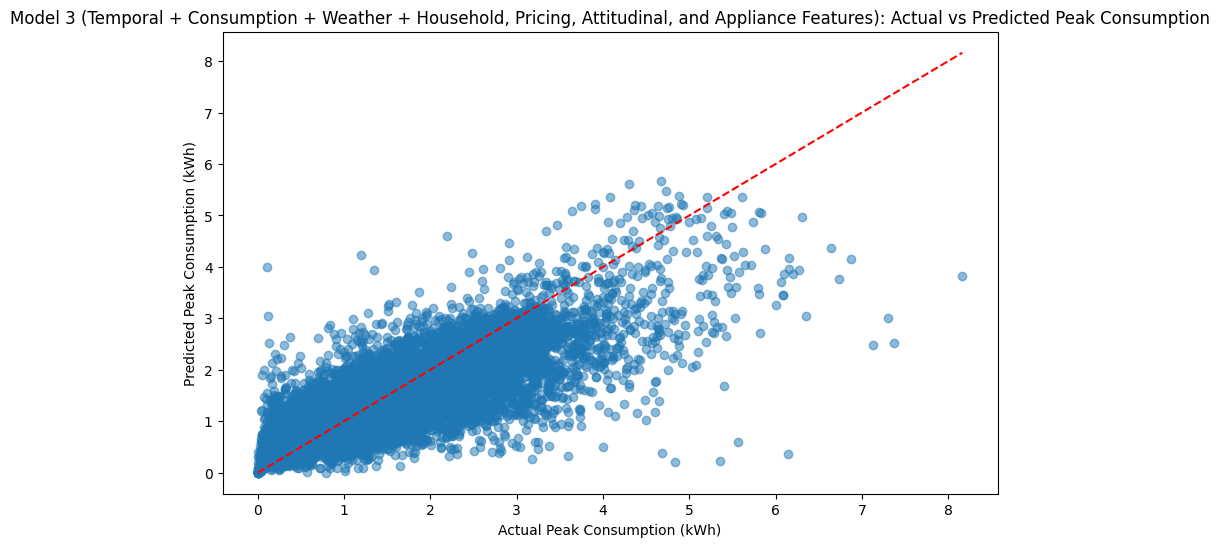

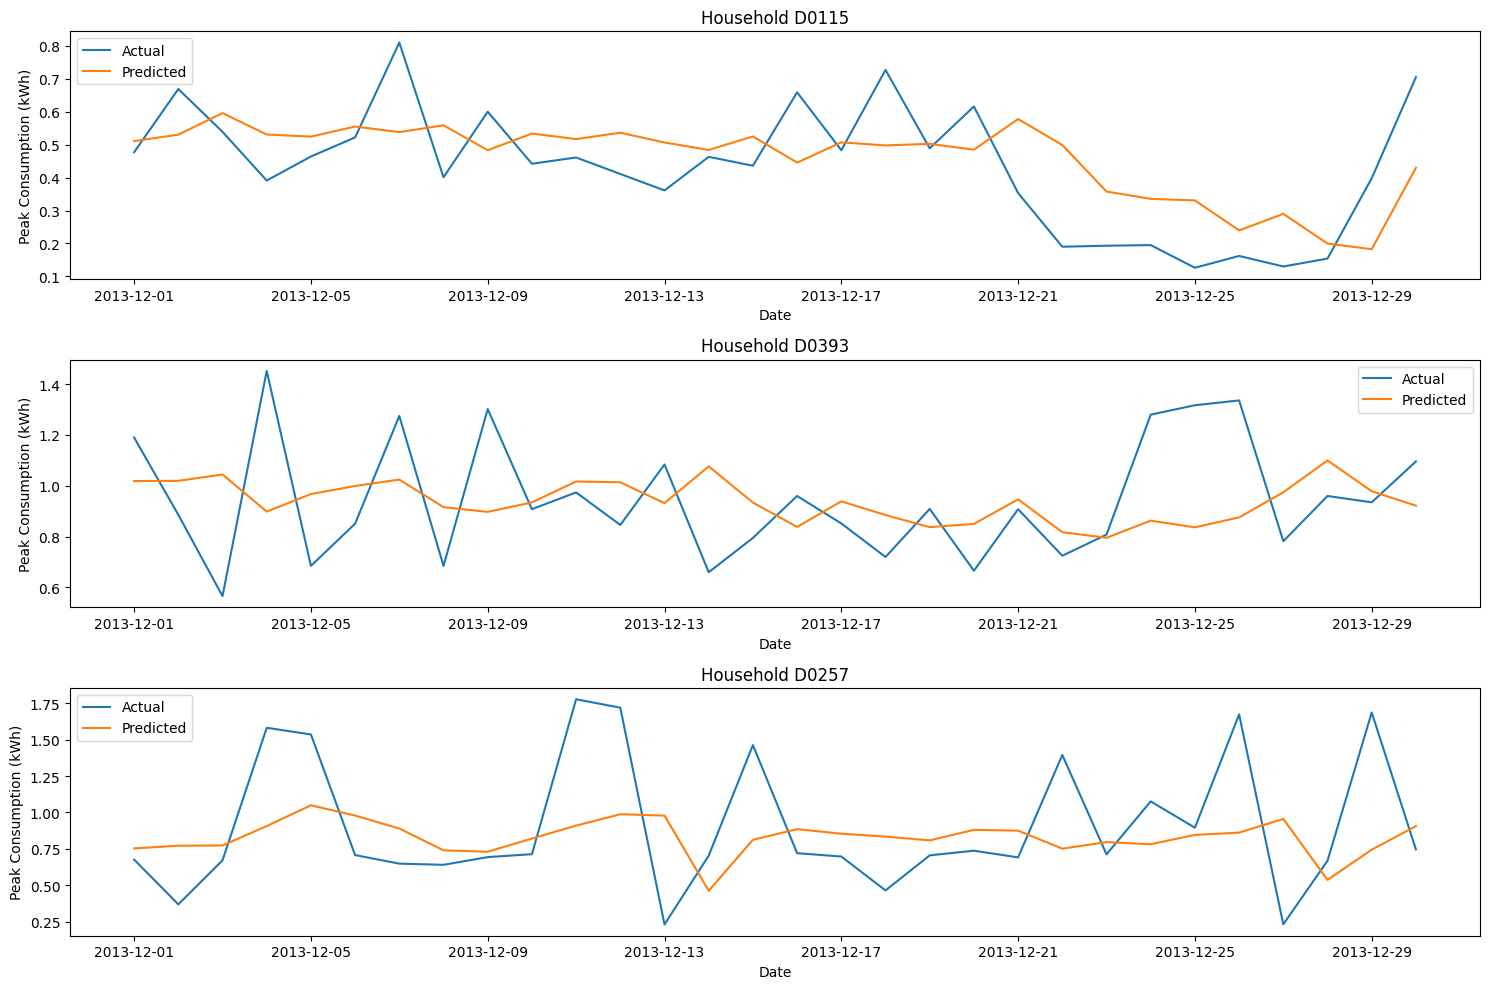

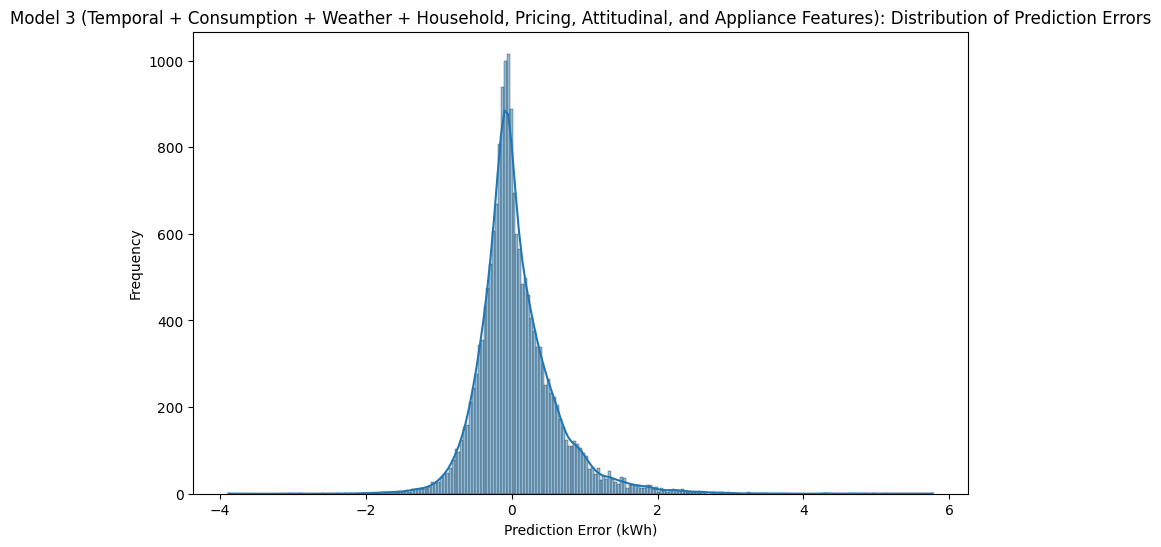


Summary Statistics for Model 3 (Temporal + Consumption + Weather + Household, Pricing, Attitudinal, and Appliance Features):
Mean Error: 0.0688
Median Error: -0.0246
Standard Deviation of Error: 0.5464
5th Percentile of Error: -0.6357
95th Percentile of Error: 1.0312

___________________________________________________________
Model 4 (Only Top 15 Features from Model 3):
  Avg Train MAE: 0.3133
  Avg Train MAPE: 39.1597%
  Avg Train WAPE: 28.1623%
  Avg Train R²: 0.7085
  Avg Validation MAE: 0.3477
  Avg Validation MAPE: 44.3078%
  Avg Validation WAPE: 31.0137%
  Avg Validation R²: 0.5938
  Test MAE: 0.3798
  Test MAPE: 47.0304%
  Test WAPE: 29.6546%
  Test R²: 0.6419
  Number of features: 15
  Top 15 Feature Importances: [('avg_peak_7d', 0.4933499), ('avg_peak_3d', 0.16978784), ('consumption_peak_today', 0.11033916), ('consumption_sum_today', 0.04984802), ('max_peak_7d', 0.022242332), ('uses_electric_heater', 0.021855699), ('max_peak_3d', 0.016775507), ('tumble_dryer_ownership', 0.01

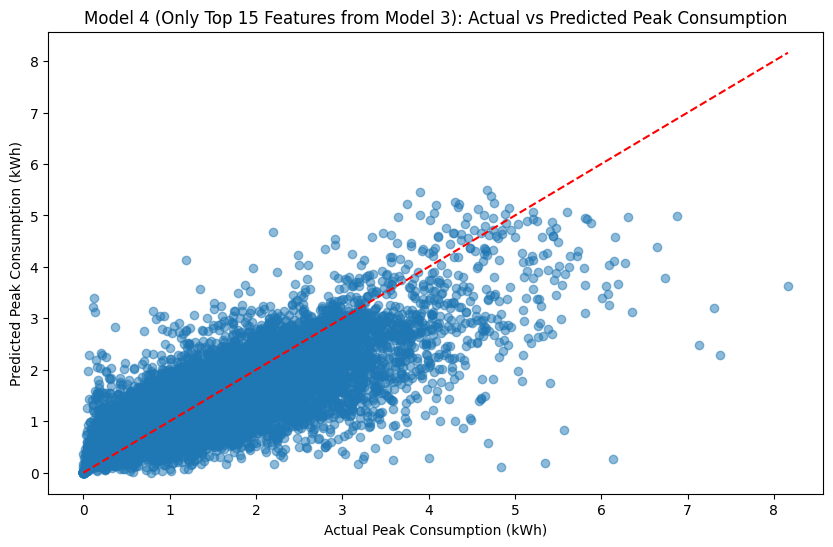

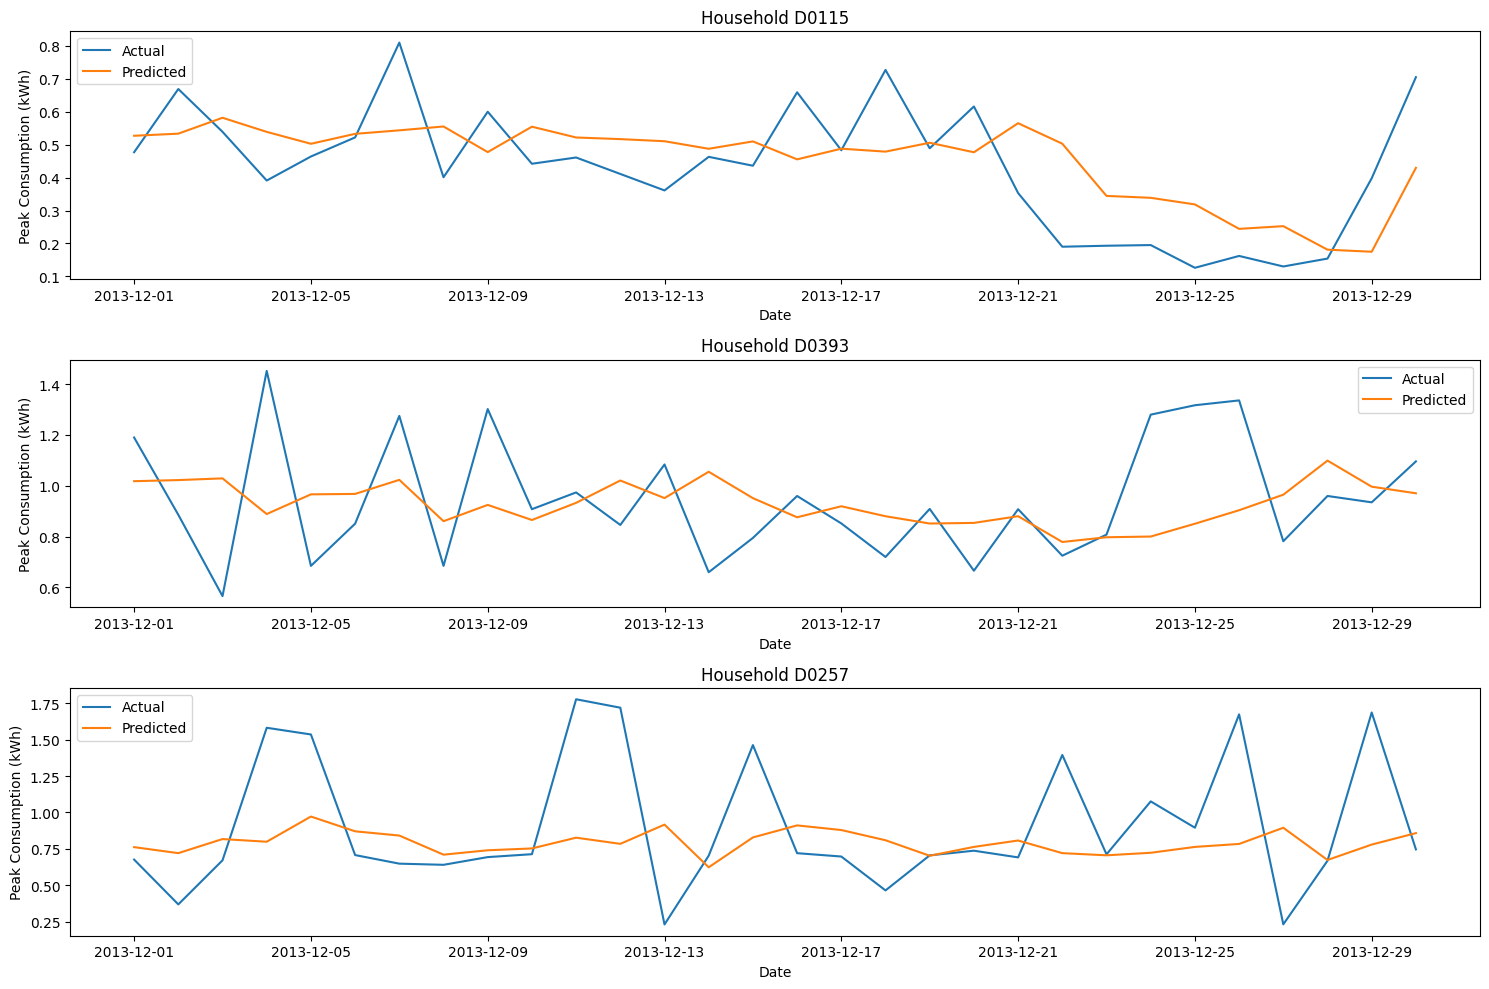

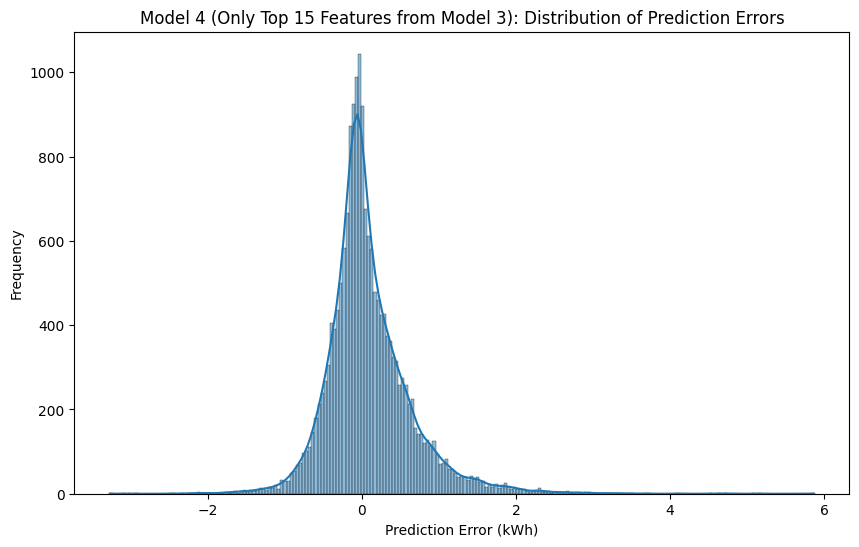


Summary Statistics for Model 4 (Only Top 15 Features from Model 3):
Mean Error: 0.0871
Median Error: -0.0070
Standard Deviation of Error: 0.5540
5th Percentile of Error: -0.6295
95th Percentile of Error: 1.0743

___________________________________________________________
Model 5 (Model 3 with Aggregated Household Features):
  Avg Train MAE: 0.2853
  Avg Train MAPE: 35.2356%
  Avg Train WAPE: 25.6471%
  Avg Train R²: 0.7577
  Avg Validation MAE: 0.3380
  Avg Validation MAPE: 43.7429%
  Avg Validation WAPE: 30.1461%
  Avg Validation R²: 0.6184
  Test MAE: 0.3742
  Test MAPE: 48.2494%
  Test WAPE: 29.2139%
  Test R²: 0.6553
  Number of features: 94
  Top 15 Feature Importances: [('avg_peak_7d', 0.2799963), ('avg_peak_3d', 0.1407996), ('consumption_peak_today', 0.062666364), ('consumption_sum_today', 0.055891033), ('max_peak_7d', 0.019096687), ('uses_electric_heater', 0.015443262), ('prev_day_peak', 0.012680859), ('tumble_dryer_ownership', 0.0106381085), ('household_size', 0.009684723), (

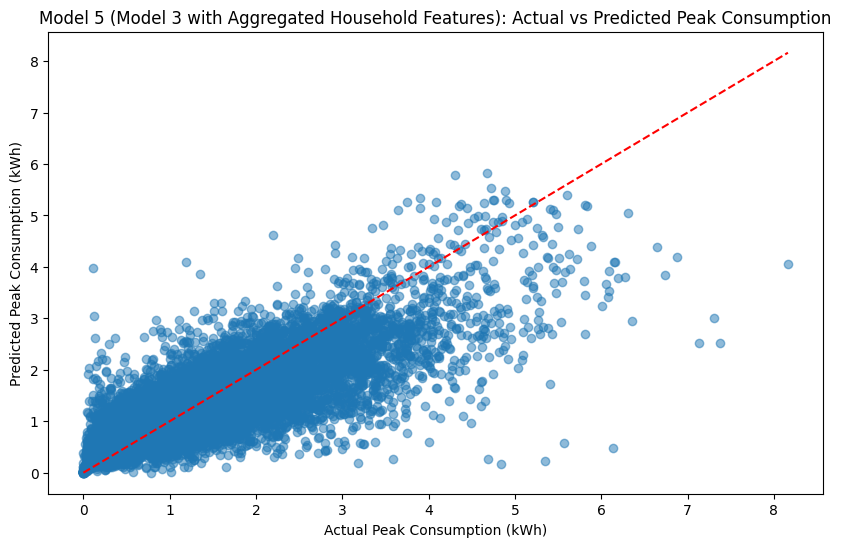

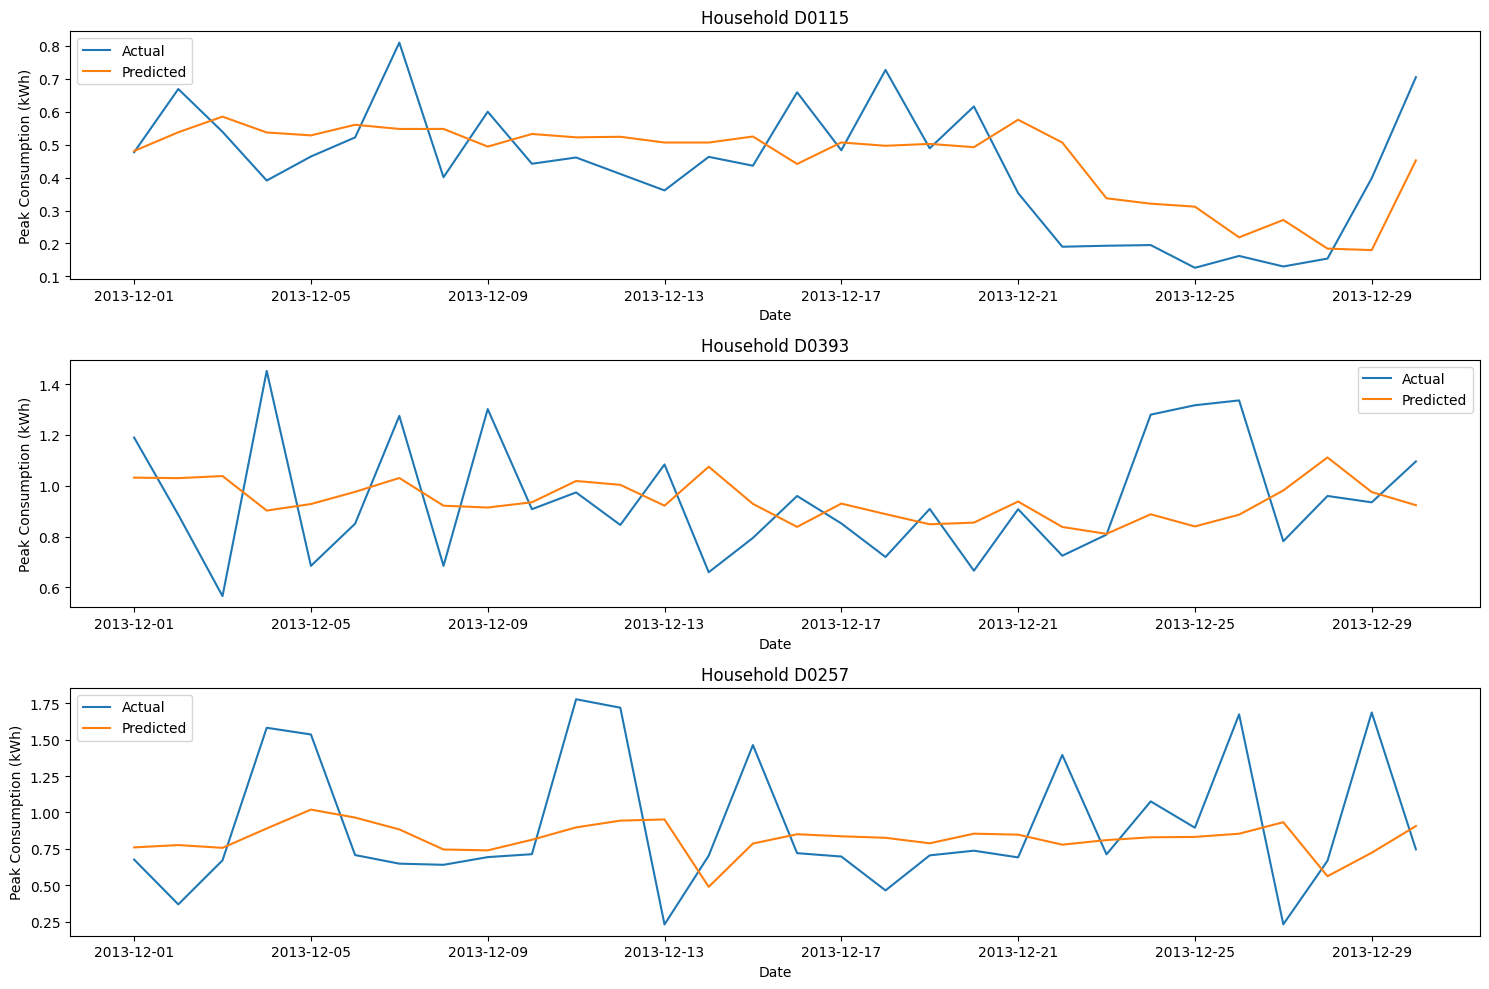

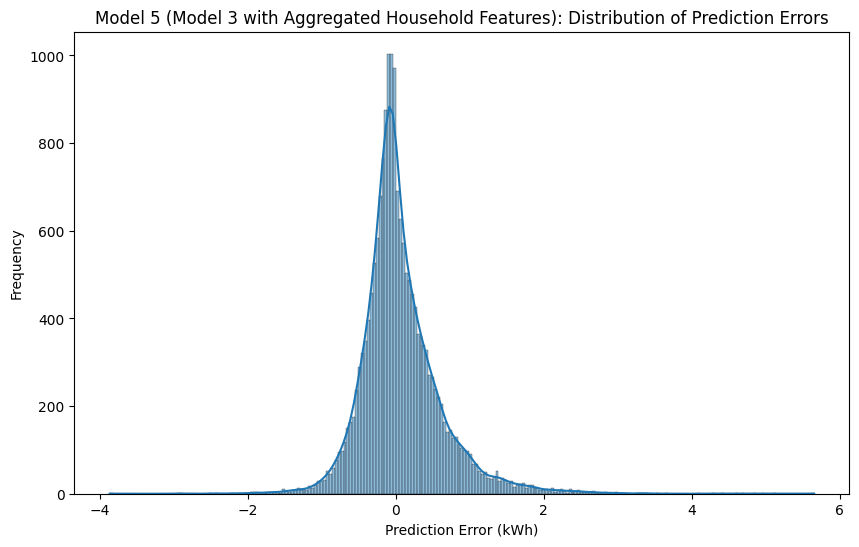


Summary Statistics for Model 5 (Model 3 with Aggregated Household Features):
Mean Error: 0.0709
Median Error: -0.0223
Standard Deviation of Error: 0.5455
5th Percentile of Error: -0.6393
95th Percentile of Error: 1.0340

___________________________________________________________
Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features):
  Avg Train MAE: 0.3003
  Avg Train MAPE: 37.3670%
  Avg Train WAPE: 26.9914%
  Avg Train R²: 0.7340
  Avg Validation MAE: 0.3413
  Avg Validation MAPE: 44.2972%
  Avg Validation WAPE: 30.4407%
  Avg Validation R²: 0.6120
  Test MAE: 0.3770
  Test MAPE: 48.7748%
  Test WAPE: 29.4360%
  Test R²: 0.6516
  Number of features: 57
  Top 15 Feature Importances: [('avg_peak_7d', 0.3719694), ('avg_peak_3d', 0.12827441), ('consumption_peak_today', 0.10119003), ('consumption_sum_today', 0.052223515), ('max_peak_3d', 0.026908603), ('max_peak_7d', 0.024308978), ('electric_heating_score', 0.013138763), ('same_day_last_week_peak', 0.0127026

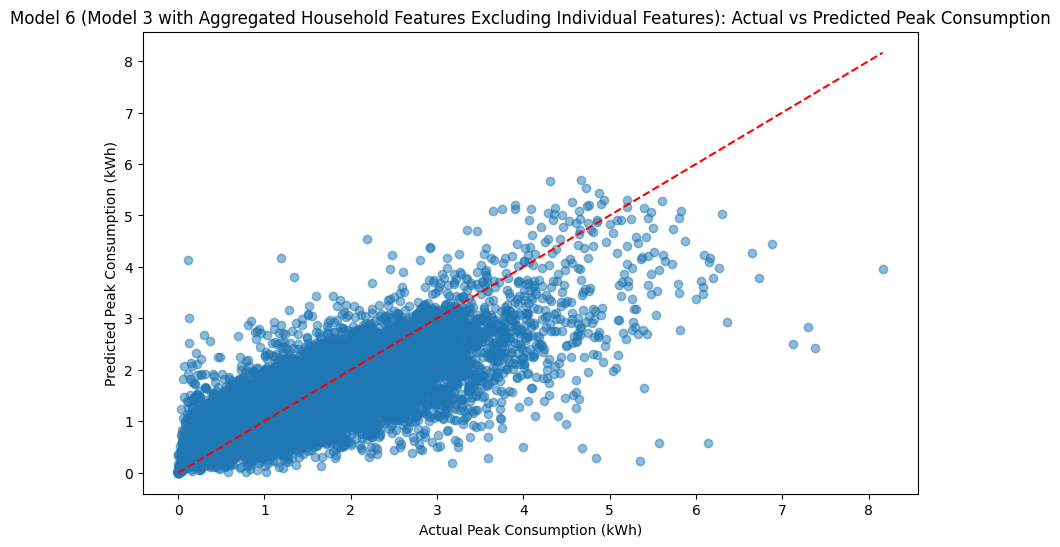

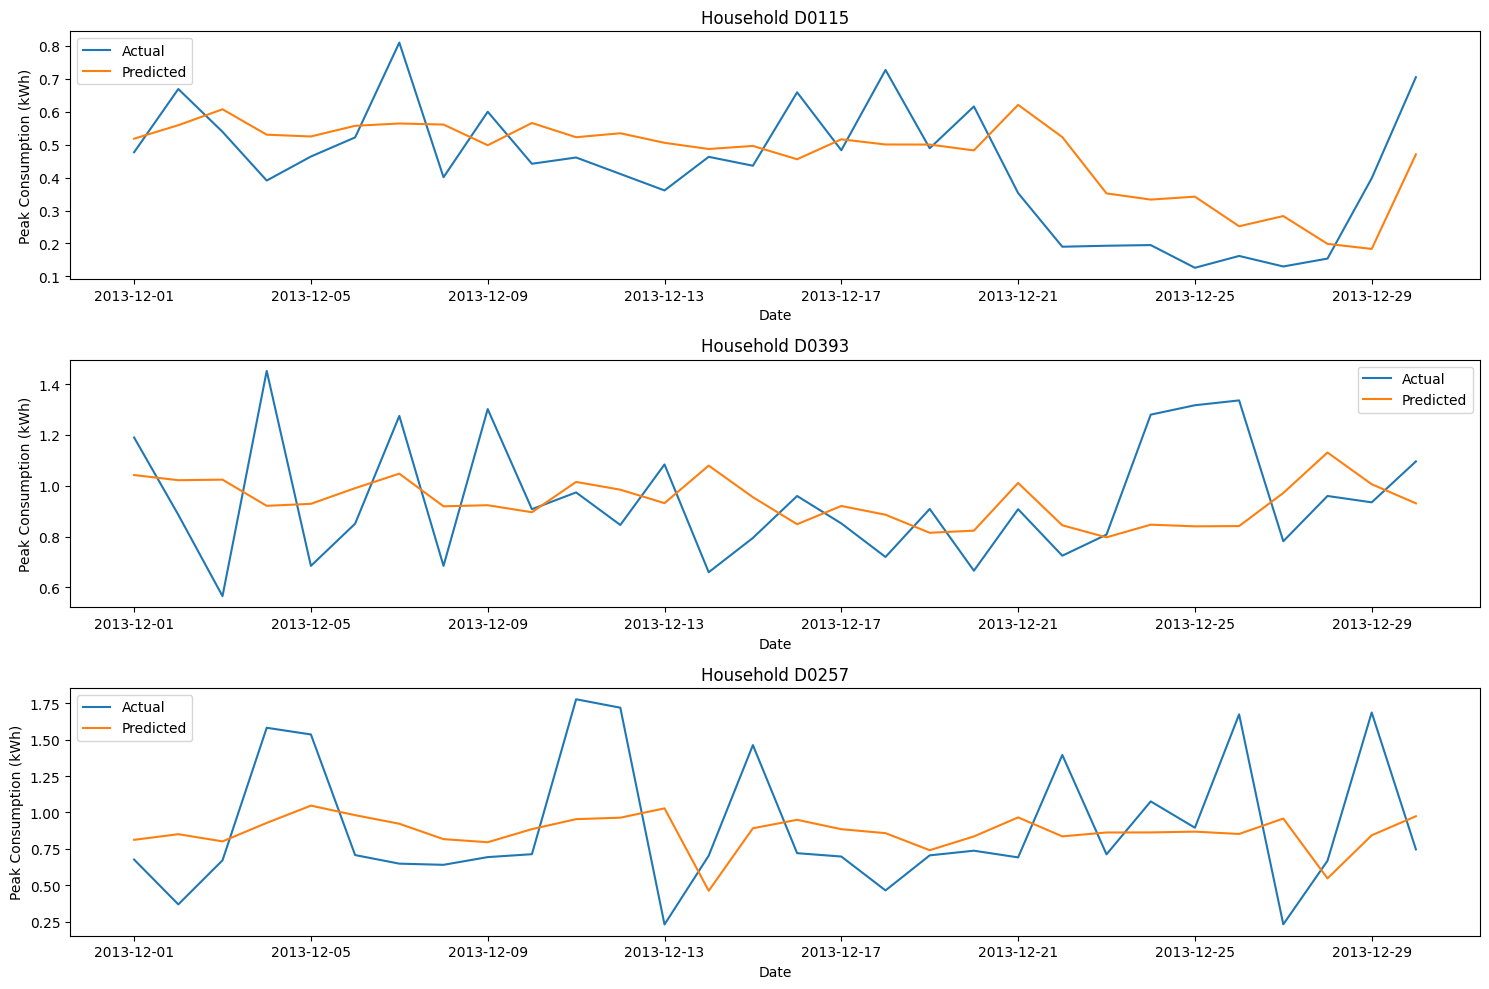

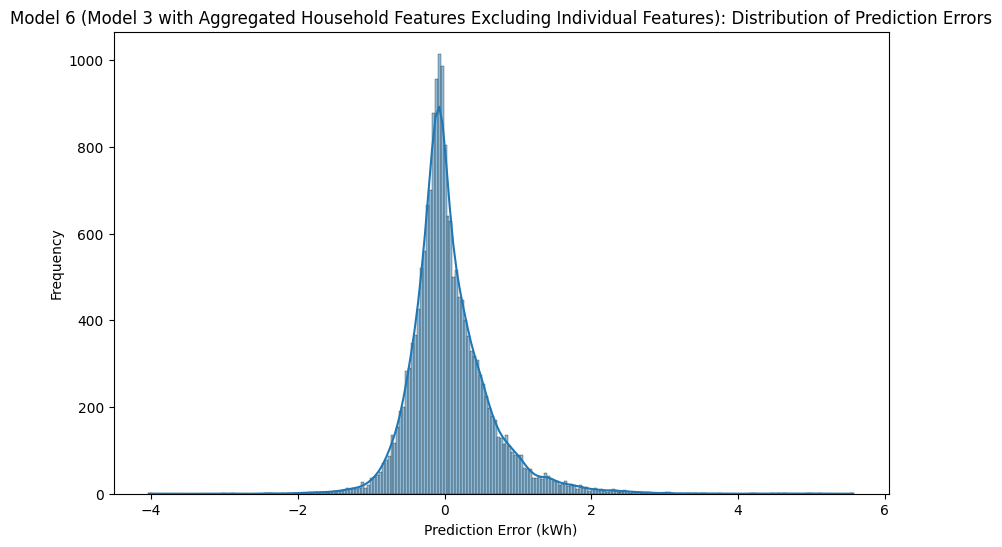


Summary Statistics for Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features):
Mean Error: 0.0690
Median Error: -0.0248
Standard Deviation of Error: 0.5488
5th Percentile of Error: -0.6401
95th Percentile of Error: 1.0439

___________________________________________________________
Model 7 (Only Top 15 Features from Model 6):
  Avg Train MAE: 0.3095
  Avg Train MAPE: 38.4590%
  Avg Train WAPE: 27.8169%
  Avg Train R²: 0.7158
  Avg Validation MAE: 0.3466
  Avg Validation MAPE: 44.0708%
  Avg Validation WAPE: 30.9163%
  Avg Validation R²: 0.5966
  Test MAE: 0.3795
  Test MAPE: 46.3191%
  Test WAPE: 29.6288%
  Test R²: 0.6438
  Number of features: 15
  Top 15 Feature Importances: [('avg_peak_7d', 0.4986073), ('avg_peak_3d', 0.17513858), ('consumption_peak_today', 0.1113496), ('consumption_sum_today', 0.050911624), ('max_peak_7d', 0.02624479), ('electric_heating_score', 0.01736947), ('same_day_last_week_peak', 0.015688319), ('day_of_week_sin', 0.014164355), ('t

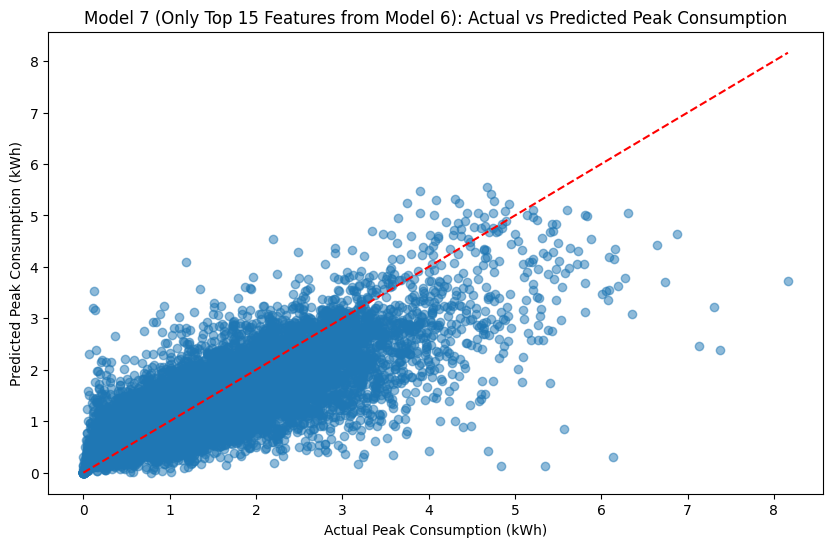

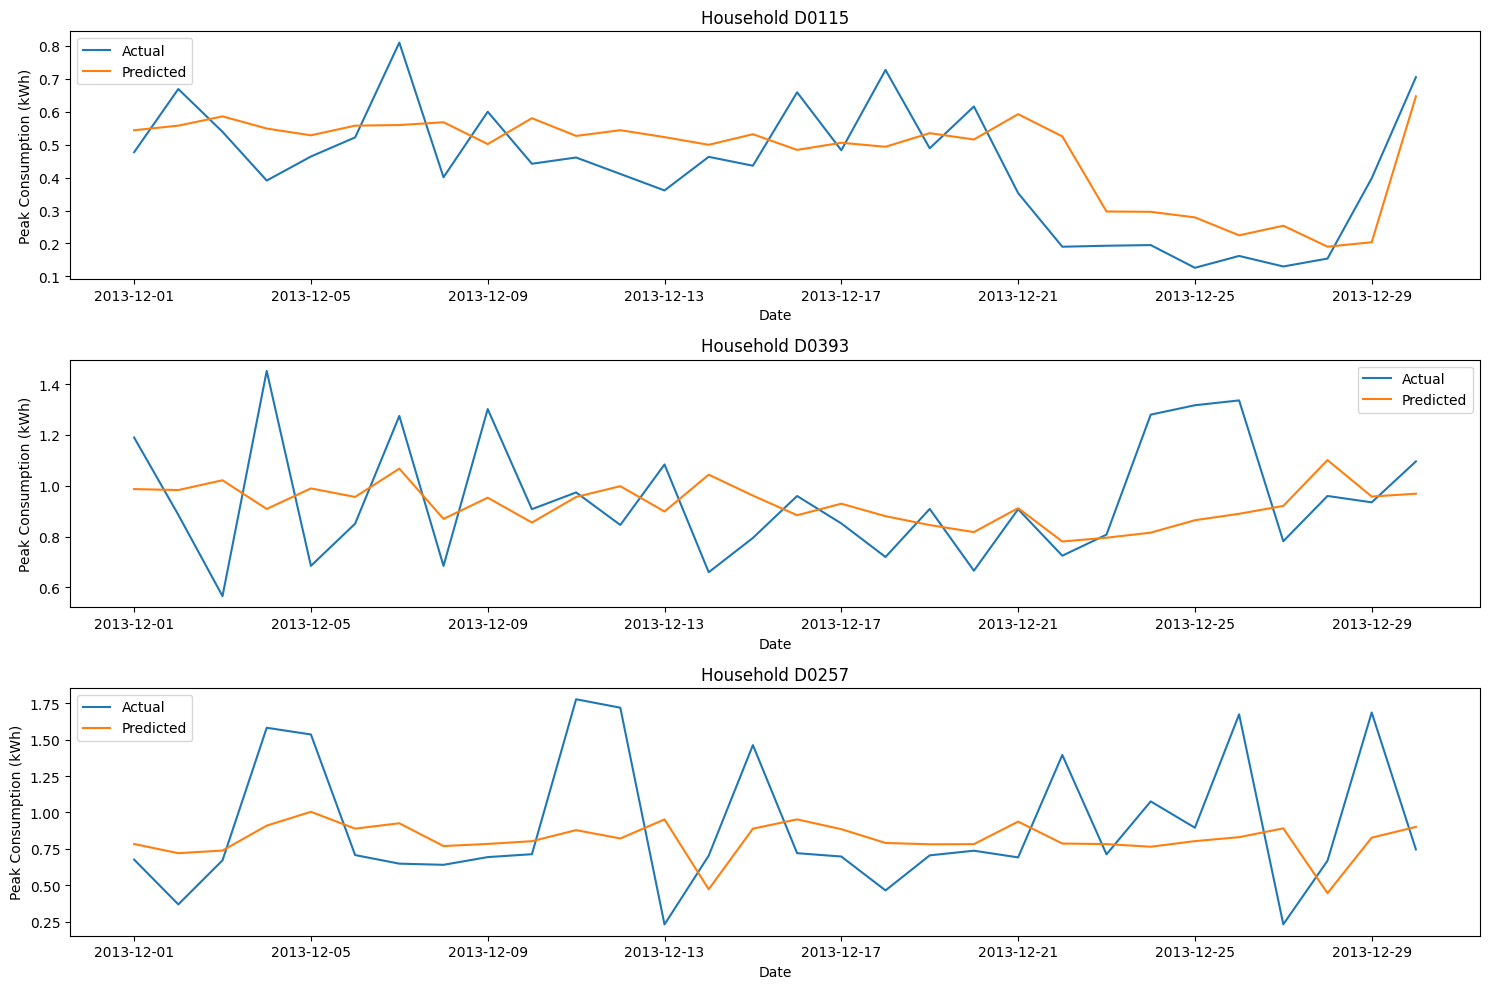

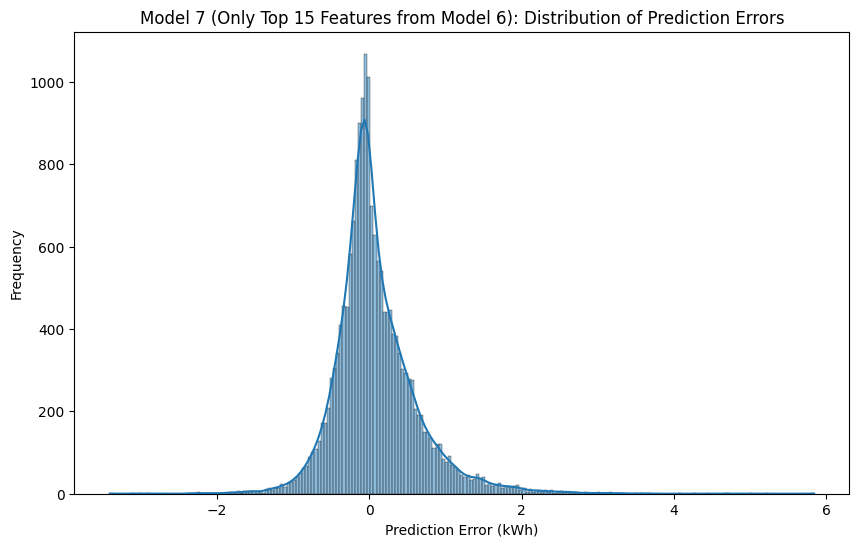


Summary Statistics for Model 7 (Only Top 15 Features from Model 6):
Mean Error: 0.0871
Median Error: -0.0073
Standard Deviation of Error: 0.5525
5th Percentile of Error: -0.6347
95th Percentile of Error: 1.0669

___________________________________________________________


In [9]:
# Model 5: Use all the features from model 3 + aggregated features
model_5_features = model_3_features + newly_aggregated_features

# Model 6: Same as Model 5 but without the individual features (retain only the aggregated features)
columns_used_for_aggregation = [
    'heating_manual_boiler', 'heating_thermostatic_valves', 
    'heating_auto_set_times', 'heating_auto_temp_control', 'heating_not_sure',
    'count_cooking_appliances', 'count_laundry_appliances', 'count_kitchen_appliances', 
    'count_heating_water_appliances', 'count_entertainment_devices', 'count_computing_devices',
    'count_tv', 'count_fridges_and_freezers', 'count_energy_saving_devices', 
    'washer-dryer_combined_ownership', 'washing_machine_ownership', 'tumble_dryer_ownership',
    'dishwasher_ownership', 'electric_space_heating_ownership', 'household_size', 
    'count_rooms', 'electric_central_heating', 'uses_electric_heater'
] + fixed_schedule_cols + timer_use_cols

model_6_features = [feature for feature in model_5_features if feature not in columns_used_for_aggregation]

# Model 5 and Model 6 training
model_5, mae_5, mape_5, wape_5, r2_5, importances_5, avg_train_mae_5, avg_train_mape_5, avg_train_wape_5, avg_train_r2_5, avg_val_mae_5, avg_val_mape_5, avg_val_wape_5, avg_val_r2_5, test_predictions_5, y_test_5, test_household_ids_5, test_dates_5 = run_model(model_5_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 5 (Model 3 with Aggregated Household Features)")
model_6, mae_6, mape_6, wape_6, r2_6, importances_6, avg_train_mae_6, avg_train_mape_6, avg_train_wape_6, avg_train_r2_6, avg_val_mae_6, avg_val_mape_6, avg_val_wape_6, avg_val_r2_6, test_predictions_6, y_test_6, test_household_ids_6, test_dates_6 = run_model(model_6_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features)")

# Model 7: Use only the top 15 features from importances_6
model_7_features = [feature for feature, importance in sorted(importances_6.items(), key=lambda item: item[1], reverse=True)[:15]]
model_7, mae_7, mape_7, wape_7, r2_7, importances_7, avg_train_mae_7, avg_train_mape_7, avg_train_wape_7, avg_train_r2_7, avg_val_mae_7, avg_val_mape_7, avg_val_wape_7, avg_val_r2_7, test_predictions_7, y_test_7, test_household_ids_7, test_dates_7 = run_model(model_7_features, 'cbrt_consumption_peak_next_day', df, folds, param_grid, "Model 7 (Only Top 15 Features from Model 6)")

# Final comparison of all the models
models = [
    ("Model 3 (Temporal + Consumption + Weather + Household, Pricing, Attitudinal, and Appliance Features)", mae_3, mape_3, wape_3, r2_3, model_3_features, avg_train_mae_3, avg_train_mape_3, avg_train_wape_3, avg_train_r2_3, avg_val_mae_3, avg_val_mape_3, avg_val_wape_3, avg_val_r2_3, importances_3, test_predictions_3, y_test_3, test_household_ids_3, test_dates_3),
    ("Model 4 (Only Top 15 Features from Model 3)", mae_4, mape_4, wape_4, r2_4, model_4_features, avg_train_mae_4, avg_train_mape_4, avg_train_wape_4, avg_train_r2_4, avg_val_mae_4, avg_val_mape_4, avg_val_wape_4, avg_val_r2_4, importances_4, test_predictions_4, y_test_4, test_household_ids_4, test_dates_4),
    ("Model 5 (Model 3 with Aggregated Household Features)", mae_5, mape_5, wape_5, r2_5, model_5_features, avg_train_mae_5, avg_train_mape_5, avg_train_wape_5, avg_train_r2_5, avg_val_mae_5, avg_val_mape_5, avg_val_wape_5, avg_val_r2_5, importances_5, test_predictions_5, y_test_5, test_household_ids_5, test_dates_5),
    ("Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features)", mae_6, mape_6, wape_6, r2_6, model_6_features, avg_train_mae_6, avg_train_mape_6, avg_train_wape_6, avg_train_r2_6, avg_val_mae_6, avg_val_mape_6, avg_val_wape_6, avg_val_r2_6, importances_6, test_predictions_6, y_test_6, test_household_ids_6, test_dates_6),
    ("Model 7 (Only Top 15 Features from Model 6)", mae_7, mape_7, wape_7, r2_7, model_7_features, avg_train_mae_7, avg_train_mape_7, avg_train_wape_7, avg_train_r2_7, avg_val_mae_7, avg_val_mape_7, avg_val_wape_7, avg_val_r2_7, importances_7, test_predictions_7, y_test_7, test_household_ids_7, test_dates_7)
]

print("\n--- Final Model Comparison ---")
for model_name, mae, mape, wape, r2, features, avg_train_mae, avg_train_mape, avg_train_wape, avg_train_r2, avg_val_mae, avg_val_mape, avg_val_wape, avg_val_r2, importances, test_predictions, y_test, test_household_ids, test_dates in models:
    print(f"{model_name}:")
    print(f"  Avg Train MAE: {avg_train_mae:.4f}")
    print(f"  Avg Train MAPE: {avg_train_mape:.4f}%")
    print(f"  Avg Train WAPE: {avg_train_wape:.4f}%")
    print(f"  Avg Train R²: {avg_train_r2:.4f}")
    print(f"  Avg Validation MAE: {avg_val_mae:.4f}")
    print(f"  Avg Validation MAPE: {avg_val_mape:.4f}%")
    print(f"  Avg Validation WAPE: {avg_val_wape:.4f}%")
    print(f"  Avg Validation R²: {avg_val_r2:.4f}")
    print(f"  Test MAE: {mae:.4f}")
    print(f"  Test MAPE: {mape:.4f}%")
    print(f"  Test WAPE: {wape:.4f}%")
    print(f"  Test R²: {r2:.4f}")
    print(f"  Number of features: {len(features)}")
    print(f"  Top 15 Feature Importances: {sorted(importances.items(), key=lambda item: item[1], reverse=True)[:15]}")
    print()

    # Plot test results for each model
    plot_test_results(model_name, test_predictions, y_test, test_household_ids, test_dates)

In [10]:
def plot_learning_curve(model, df, features, target, folds, model_name):
    train_scores, valid_scores = [], []

    for fold, (train_start, train_end, val_start, val_end) in enumerate(folds, 1):
        X_train, y_train, _, _ = create_dataset(df, train_start, train_end, features, target)
        X_val, y_val, _, _ = create_dataset(df, val_start, val_end, features, target)

        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_scores.append(custom_wape(y_train, train_pred))
        valid_scores.append(custom_wape(y_val, val_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(folds) + 1), train_scores, label='Training WAPE', marker='o')
    plt.plot(range(1, len(folds) + 1), valid_scores, label='Validation WAPE', marker='o')
    plt.xlabel('Fold')
    plt.ylabel('WAPE')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.xticks(range(1, len(folds) + 1))
    plt.show()

    print(f"Training WAPE scores: {train_scores}")
    print(f"Validation WAPE scores: {valid_scores}")

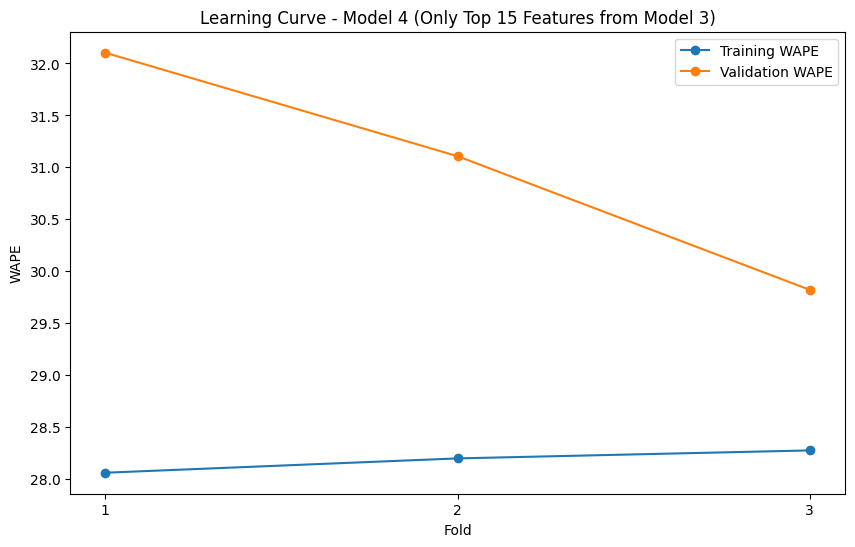

Training WAPE scores: [28.062634737519954, 28.200388908069307, 28.277178432436536]
Validation WAPE scores: [32.103001580383776, 31.107597181023987, 29.821959433500016]


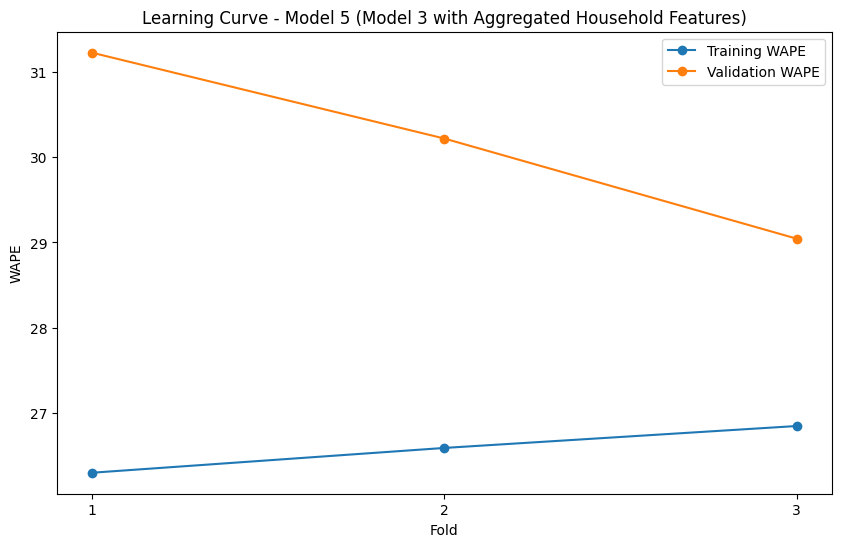

Training WAPE scores: [26.29792809049285, 26.588765025609796, 26.84584530190328]
Validation WAPE scores: [31.225323206854444, 30.218415540311007, 29.04374112859356]


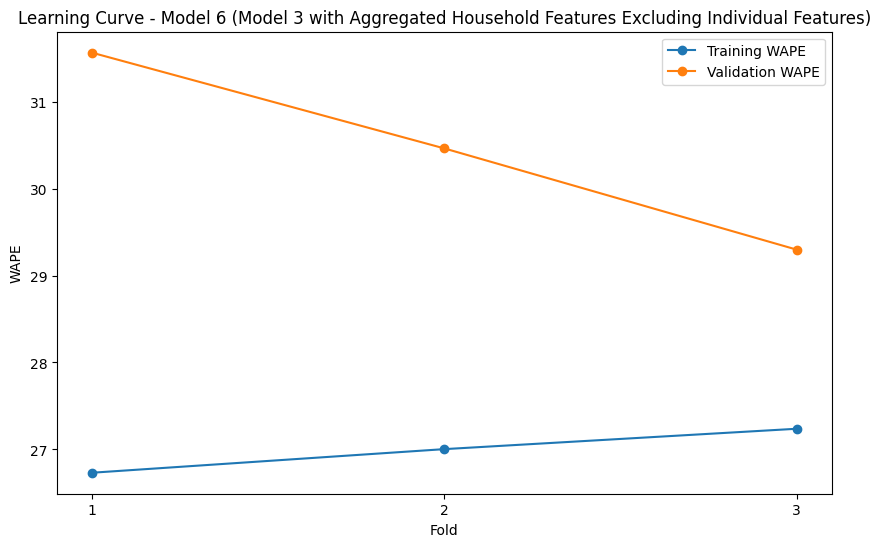

Training WAPE scores: [26.732402073742705, 27.00375775325361, 27.23801762859664]
Validation WAPE scores: [31.56241994296372, 30.461683722526438, 29.29788227485457]


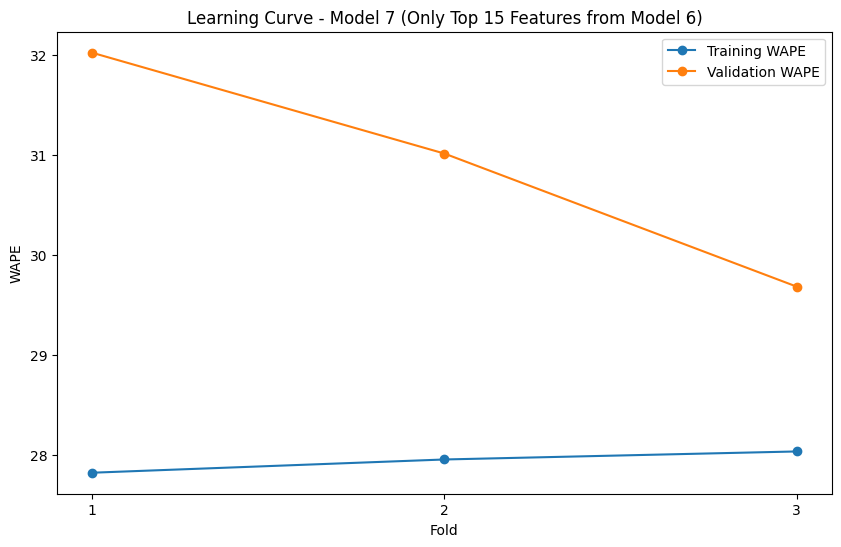

Training WAPE scores: [27.82229446083627, 27.954641859746545, 28.03495066396011]
Validation WAPE scores: [32.020986591811116, 31.01291416286273, 29.682873437028263]


In [11]:
# Plotting learning curves
plot_learning_curve(model_4, df, model_4_features, 'cbrt_consumption_peak_next_day', folds, "Model 4 (Only Top 15 Features from Model 3)")
plot_learning_curve(model_5, df, model_5_features, 'cbrt_consumption_peak_next_day', folds, "Model 5 (Model 3 with Aggregated Household Features)")
plot_learning_curve(model_6, df, model_6_features, 'cbrt_consumption_peak_next_day', folds, "Model 6 (Model 3 with Aggregated Household Features Excluding Individual Features)")
plot_learning_curve(model_7, df, model_7_features, 'cbrt_consumption_peak_next_day', folds, "Model 7 (Only Top 15 Features from Model 6)")